In [24]:
from python_speech_features import mfcc
import scipy.io.wavfile as wav
import numpy as np
from tempfile import TemporaryFile
import matplotlib.pyplot as plt
import os
import pickle
import random 
import operator
import math
import numpy as np
import os
import pandas as pd
import IPython.display as ipd
import librosa
import librosa.display
from scipy.fft import fft, ifft
from collections import Counter
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error,roc_auc_score,precision_score, confusion_matrix, make_scorer,f1_score,log_loss
from sklearn.inspection import permutation_importance

import matplotlib

from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

from scipy.stats import norm, randint, uniform, poisson, expon

pd.options.display.max_columns = 1000
import shap

# make window wider
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# (see https://towardsdatascience.com/enabling-notifications-in-your-jupyter-notebooks-for-cell-completion-68d82b02bbc6#:~:text=Notify%20is%20a%20Jupyter%20Notebook,and%20Firefox%20(Version%3A%2053.0.)
%load_ext jupyternotify 

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [22]:
def read_data(features,timbre_features,filename,file_timbre):
    pdread = pd.read_csv(filename)
    dataframe = pd.DataFrame({})
    pdread_timbre = pd.read_csv(file_timbre)
    
    for l in range(len(features)):
        data_feature = np.array(pdread[pdread.index==l])
        data_feature[0][1:-1]
        dataframe[features[l]]=data_feature[0][1:-1]

    for l in range(len(timbre_features)):
        data_feature = np.array(pdread_timbre[pdread_timbre.index==l])
        dataframe[timbre_features[l]]=data_feature[0][1:-1]
        
    
    mads_data = pd.read_csv('syncopation_data.csv')
    new_data = pd.DataFrame({})
    for i in folders:
        new_data = pd.concat([new_data, mads_data[mads_data['genre']==i]])
        columns_new_data = new_data.columns[2:21]
    
    for l in columns_new_data:
        dataframe[columns_new_data] = new_data[columns_new_data]
    
    mads_data2 = pd.read_csv('rythmic_data.csv')
    new_data2 = pd.DataFrame({})
    for i in folders:
        new_data2 = pd.concat([new_data2, mads_data2[mads_data2['genre']==i]])
        columns_new_data2 = new_data2.columns[2:8]


    for l in columns_new_data2:
        dataframe[columns_new_data2] = new_data2[columns_new_data2]
    

    return(dataframe,columns_new_data,columns_new_data2)


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [3]:
# load all data
features = ['zerocrossing','spectralrolloff','chromagramstd','chromagrammean','fourier_std','fourier_mean','chroma_cens', 'class']
timbre_features = ['hardness','depth','brightness','roughness','warmth','sharpness','boominess','reverb']
folders = ['pop','jazz','blues','classical','hiphop','metal','rock','reggae','disco','country']

dataframe, columns_new_data,columns_new_data2 = read_data(features,timbre_features,"other_features.csv",'timbre_secure.csv')
dataframe['allEarly']=dataframe['overlap1Early']+dataframe['overlap2Early']+dataframe['overlap3Early']+dataframe['overlap4Early']+dataframe['overlap5Early']+dataframe['overlap6Early']
dataframe['allLate']=dataframe['overlap1Late']+dataframe['overlap2Late']+dataframe['overlap3Late']+dataframe['overlap4Late']+dataframe['overlap5Late']+dataframe['overlap6Late']
dataframe['synco'] = dataframe['allEarly']-dataframe['allLate']
dataframe.head(5)

,zerocrossing,spectralrolloff,chromagramstd,chromagrammean,fourier_std,fourier_mean,chroma_cens,class,hardness,depth,brightness,roughness,warmth,sharpness,boominess,reverb,overlap0,overlap1,overlap1Early,overlap1Late,overlap2,overlap2Early,overlap2Late,overlap3,overlap3Early,overlap3Late,overlap4,overlap4Early,overlap4Late,overlap5,overlap5Early,overlap5Late,overlap6,overlap6Early,overlap6Late,tempo,tempoHarmonic,tempoPercussive,onBeat,onBeatHarmonic,onBeatPercussive,allEarly,allLate,synco
0,490.0,7916.478436,0.286046,61.724392,155.002121,0.389286,0.301558,0.0,62.184903,64.482713,64.901826,54.344498,47.473584,58.247913,31.572225,1.0,1.753658,0.210424,0.013987,0.620453,0.040014,0.012410,0.176721,0.054571,0.025400,0.455789,0.047221,0.009912,0.108415,0.014026,0.005603,0.034720,0.011328,0.003119,0.020560,123.046875,123.046875,123.046875,0.219255,0.173677,0.175861,0.070431,1.416658,-1.346226
1,704.0,8049.560283,0.306736,98.570839,213.782852,0.413187,0.312815,0.0,63.719431,61.089713,68.271124,59.738090,45.438443,60.019366,32.193873,0.0,2.785280,0.394667,0.231321,0.139635,0.916249,0.278263,0.168726,1.532961,0.236100,0.073923,0.009115,0.002881,0.018700,0.430154,0.087305,0.016993,0.244307,0.056372,0.050570,67.999589,67.999589,67.999589,0.301049,0.216952,0.254102,0.892241,0.468547,0.423694
2,913.0,7392.282121,0.306183,71.167252,173.006790,0.417412,0.305931,0.0,61.194341,60.537756,64.919842,59.427448,46.784449,56.371713,34.493369,1.0,2.697888,0.132710,0.703458,0.026851,0.028507,0.455132,0.068784,0.018781,0.517178,0.008158,0.049385,0.087481,0.014999,0.036461,0.023254,0.011404,0.014722,0.022702,0.018540,161.499023,161.499023,161.499023,0.186501,0.139141,0.153761,1.809204,0.148736,1.660468
3,849.0,3639.036502,0.293715,44.226902,101.596466,0.407685,0.284466,0.0,59.058285,58.243250,63.018400,55.438606,48.175596,48.531268,31.120960,1.0,2.141774,0.234815,0.401124,0.182243,0.500865,0.377981,0.042896,0.631104,0.466492,0.018109,0.059323,0.058655,0.003395,0.137122,0.089858,0.013440,0.140773,0.112868,0.057044,63.024009,172.265625,63.024009,0.413590,0.136438,0.322781,1.506979,0.317127,1.189851
4,697.0,5958.993877,0.258193,89.199371,152.478058,0.384264,0.289209,0.0,62.573535,53.332775,65.535807,61.639147,44.527119,54.425945,27.943247,1.0,3.026272,0.276725,0.588319,0.049129,0.145096,0.293845,0.017441,0.138670,0.524937,0.071714,0.080301,0.139576,0.015173,0.038622,0.050418,0.016668,0.034647,0.039175,0.013946,135.999178,135.999178,135.999178,0.210587,0.190118,0.165812,1.636269,0.184070,1.452199


In [4]:
# choose a certain number of genres
dataframe_cut = pd.DataFrame({})
chosen_genres = [0,1,2,3,4,5,6,7,8,9]
#[3,5,8]

for i in chosen_genres:
    dataframe_cut = dataframe_cut.append(dataframe[dataframe['class']==i])

dataframe_cut['class_num'] = pd.factorize(dataframe_cut['class'])[0]

In [80]:
# choose which variables to look at
df_1=[]
train_features = np.concatenate([['zerocrossing','spectralrolloff','chromagramstd','chromagrammean','fourier_std',
                  'fourier_mean','chroma_cens','hardness','depth','brightness','roughness','warmth',
                  'sharpness','boominess','reverb'],
                                 ['synco'],
                                 columns_new_data, 
                                 columns_new_data2])


# train_features = np.concatenate([['zerocrossing','spectralrolloff','chromagramstd','chromagrammean','fourier_std',
#                   'fourier_mean','chroma_cens','hardness','depth','brightness','roughness','warmth',
#                   'sharpness','boominess'],
#                                  ['synco', 'overlap0'],
#                                  columns_new_data2]) 
# #                                  columns_new_data2])

# top15_features = ['fourier_mean',
#                  'overlap0',
#                  'spectralrolloff',
#                  'chroma_cens',
#                  'fourier_std',
#                  'roughness',
#                  'hardness',
#                  'onBeatHarmonic',
#                  'chromagrammean',
#                  'chromagramstd',
#                  'boominess',
#                  'depth',
#                  'onBeat',
#                  'warmth',
#                  'sharpness']

top15_features_OLD = ['fourier_mean',
                 'overlap0',
                 'chroma_cens',
                 'spectralrolloff',
                 'roughness',
                 'fourier_std',
                 'onBeatHarmonic',
                 'chromagrammean',
                 'hardness',
                 'depth',
                 'chromagramstd',
                 'boominess',
                 'warmth',
                 'onBeatPercussive',
                 'overlap5']

top10_features_old = ['overlap0',
                 'fourier_mean',
                 'roughness',
                 'spectralrolloff',
                 'chroma_cens',
                 'fourier_std',
                 'onBeat',
                 'onBeatHarmonic',
                 'chromagramstd',
                 'chromagrammean']

top15_features = ['overlap0',
                 'fourier_mean',
                 'roughness',
                 'chroma_cens',
                 'spectralrolloff',
                 'fourier_std',
                 'hardness',
                 'warmth',
                 'chromagrammean',
                 'onBeatHarmonic',
                 'boominess',
                 'sharpness',
                 'onBeatPercussive',
                 'tempoHarmonic',
                 'onBeat']
top10_features = ['overlap0',
                 'fourier_mean',
                 'chroma_cens',
                 'roughness',
                 'spectralrolloff',
                 'fourier_std',
                 'onBeatHarmonic',
                 'boominess',
                 'warmth',
                 'chromagrammean']

top7_features = ['overlap0',
                 'fourier_mean',
                 'spectralrolloff',
                 'roughness',
                 'chroma_cens',
                 'fourier_std',
                 'warmth']

moreThan10pctFeats = ['fourier_mean', 'overlap0', 'chroma_cens', 'roughness',
       'spectralrolloff', 'fourier_std', 'chromagrammean', 'hardness',
       'boominess', 'onBeatHarmonic', 'overlap6', 'overlap5', 'warmth',
       'sharpness', 'chromagramstd', 'onBeatPercussive', 'overlap6Late',
       'overlap2Early', 'onBeat', 'brightness', 'overlap3Late',
       'tempoHarmonic', 'overlap5Early', 'overlap4Late', 'depth',
       'overlap4', 'overlap5Late', 'tempo', 'overlap2', 'overlap3Early',
       'tempoPercussive', 'overlap2Late', 'overlap1Early',
       'overlap4Early', 'reverb', 'overlap1', 'overlap6Early',
       'zerocrossing', 'synco', 'overlap3', 'overlap1Late']


top10SHAP = ['fourier_mean', 'overlap0','roughness','spectralrolloff','chroma_cens','chromagrammean','fourier_std','overlap5','hardness']
train_features = top10SHAP


df_1=dataframe_cut[train_features]

#Scaling using the Standard Scaler
sc_1=StandardScaler()
sc_1.fit(df_1)
X_1=pd.DataFrame(sc_1.fit_transform(df_1))#, columns=train_features)

Y_1=dataframe_cut['class_num']
X_1.head(5)
len(moreThan10pctFeats)

41

In [81]:
# set up LGBM classifier
params={}
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='multiclass' #Multi-class target feature
params['metric']='multi_logloss' #metric for multi-class
# params['metric']='f1' #metric for multi-class
# params['max_depth']=10 # sofus param value
params['max_depth'] = 6 # Mads param value
params['num_class']=10
# params['num_leaves']=14 # Sofus param value
params['num_leaves']=9 # Mads param value
params['force_col_wise']=True
params['verbose'] = -2
params['learning_rate']=0.1 # Sofus param value
# params['learning_rate']= 0.002
params['learning_rate']= 0.0008137059759269703
params['n_estimators']=30000
epochs = 500
#len(os.listdir()) #no.of unique values in the target class not inclusive of the end value
#training the model
score_array=[]

# optimal after grid search 'learning_rate': 0.0008137059759269703, 'max_depth': 6, 'num_leaves': 9

evals_result={}

In [82]:
# run LGBM classifier
test = False
Nparams=100

# testsize = 0.2

NstopRound = 1000


if test==True:
    score_array=[]
    runNo = []
    for param in range(Nparams):
        print('running test {:d} of {:d}'.format(param+1, Nparams))
        #params['max_depth']=param+1
        X_train,X_test,y_train,y_test=train_test_split(X_1,Y_1,test_size=testsize,random_state=param)
        d_train=lgb.Dataset(X_train, label=y_train)

        clf=lgb.train(params,d_train,param*100+1)

        y_pred_1=clf.predict(X_test)

        y_pred_m = [np.argmax(line) for line in y_pred_1]

        score = precision_score(y_pred_m,y_test,average=None).mean()
        score_array.append(score)
        runNo.append(param)
    plt.figure('test precision scores')
    plt.plot(np.arange(0,Nparams,1),score_array)
    plt.ylim([0,1])
    plt.grid()
else:
    X_train,X_test,y_train,y_test=train_test_split(X_1,Y_1,test_size=0.3,random_state=42)
    X_val, X_test, y_val, y_test=train_test_split(X_test, y_test, test_size=0.66,random_state=42)
    d_train=lgb.Dataset(X_train, label=y_train)
    d_val = lgb.Dataset(X_val, label=y_val)
    
    clf = lgb.LGBMClassifier()
    clf.set_params(**params)
    clf.fit(X_train, y_train, eval_set =[(X_val,y_val)],early_stopping_rounds = NstopRound)
#     clf=lgb.train(params,d_train ,epochs)

    y_pred_1=clf.predict(X_test)

    y_pred_m = [np.argmax(line) for line in y_pred_1]

#     score = precision_score(y_pred_m,y_test,average=None).mean()
    score = precision_score(y_pred_1,y_test,average=None).mean()
    

print(score)
# print(np.array(y_test)-np.array(y_pred_m))
print(np.array(y_test)-np.array(y_pred_1))
print(y_pred_1)

%notify -m "First fitting done!"

[1]	valid_0's multi_logloss: 2.30151
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's multi_logloss: 2.29837
[3]	valid_0's multi_logloss: 2.29519
[4]	valid_0's multi_logloss: 2.29209
[5]	valid_0's multi_logloss: 2.28895
[6]	valid_0's multi_logloss: 2.2859
[7]	valid_0's multi_logloss: 2.28288
[8]	valid_0's multi_logloss: 2.27986
[9]	valid_0's multi_logloss: 2.27679
[10]	valid_0's multi_logloss: 2.27387
[11]	valid_0's multi_logloss: 2.27083
[12]	valid_0's multi_logloss: 2.26796
[13]	valid_0's multi_logloss: 2.26501
[14]	valid_0's multi_logloss: 2.26202
[15]	valid_0's multi_logloss: 2.2592
[16]	valid_0's multi_logloss: 2.25625
[17]	valid_0's multi_logloss: 2.25334
[18]	valid_0's multi_logloss: 2.25051
[19]	valid_0's multi_logloss: 2.24767
[20]	valid_0's multi_logloss: 2.24478
[21]	valid_0's multi_logloss: 2.24199
[22]	valid_0's multi_logloss: 2.23914
[23]	valid_0's multi_logloss: 2.23634
[24]	valid_0's multi_logloss: 2.23355
[25]	valid_0's multi_logloss: 2.2307

[308]	valid_0's multi_logloss: 1.73809
[309]	valid_0's multi_logloss: 1.73701
[310]	valid_0's multi_logloss: 1.73591
[311]	valid_0's multi_logloss: 1.73478
[312]	valid_0's multi_logloss: 1.73365
[313]	valid_0's multi_logloss: 1.73263
[314]	valid_0's multi_logloss: 1.73155
[315]	valid_0's multi_logloss: 1.7305
[316]	valid_0's multi_logloss: 1.7294
[317]	valid_0's multi_logloss: 1.72833
[318]	valid_0's multi_logloss: 1.72724
[319]	valid_0's multi_logloss: 1.72615
[320]	valid_0's multi_logloss: 1.72511
[321]	valid_0's multi_logloss: 1.72397
[322]	valid_0's multi_logloss: 1.72292
[323]	valid_0's multi_logloss: 1.72189
[324]	valid_0's multi_logloss: 1.72082
[325]	valid_0's multi_logloss: 1.71977
[326]	valid_0's multi_logloss: 1.71869
[327]	valid_0's multi_logloss: 1.71766
[328]	valid_0's multi_logloss: 1.71659
[329]	valid_0's multi_logloss: 1.71554
[330]	valid_0's multi_logloss: 1.71446
[331]	valid_0's multi_logloss: 1.71338
[332]	valid_0's multi_logloss: 1.71232
[333]	valid_0's multi_loglo

[617]	valid_0's multi_logloss: 1.47868
[618]	valid_0's multi_logloss: 1.47806
[619]	valid_0's multi_logloss: 1.4775
[620]	valid_0's multi_logloss: 1.47693
[621]	valid_0's multi_logloss: 1.47633
[622]	valid_0's multi_logloss: 1.47577
[623]	valid_0's multi_logloss: 1.47516
[624]	valid_0's multi_logloss: 1.4746
[625]	valid_0's multi_logloss: 1.47397
[626]	valid_0's multi_logloss: 1.47338
[627]	valid_0's multi_logloss: 1.47283
[628]	valid_0's multi_logloss: 1.47233
[629]	valid_0's multi_logloss: 1.47175
[630]	valid_0's multi_logloss: 1.47112
[631]	valid_0's multi_logloss: 1.47064
[632]	valid_0's multi_logloss: 1.47001
[633]	valid_0's multi_logloss: 1.46949
[634]	valid_0's multi_logloss: 1.46893
[635]	valid_0's multi_logloss: 1.46838
[636]	valid_0's multi_logloss: 1.46784
[637]	valid_0's multi_logloss: 1.46732
[638]	valid_0's multi_logloss: 1.46668
[639]	valid_0's multi_logloss: 1.46613
[640]	valid_0's multi_logloss: 1.46562
[641]	valid_0's multi_logloss: 1.46512
[642]	valid_0's multi_loglo

[912]	valid_0's multi_logloss: 1.34418
[913]	valid_0's multi_logloss: 1.3438
[914]	valid_0's multi_logloss: 1.34345
[915]	valid_0's multi_logloss: 1.34312
[916]	valid_0's multi_logloss: 1.34271
[917]	valid_0's multi_logloss: 1.34231
[918]	valid_0's multi_logloss: 1.34195
[919]	valid_0's multi_logloss: 1.34161
[920]	valid_0's multi_logloss: 1.34122
[921]	valid_0's multi_logloss: 1.34087
[922]	valid_0's multi_logloss: 1.34056
[923]	valid_0's multi_logloss: 1.34021
[924]	valid_0's multi_logloss: 1.33987
[925]	valid_0's multi_logloss: 1.33951
[926]	valid_0's multi_logloss: 1.33918
[927]	valid_0's multi_logloss: 1.33888
[928]	valid_0's multi_logloss: 1.33853
[929]	valid_0's multi_logloss: 1.33821
[930]	valid_0's multi_logloss: 1.33793
[931]	valid_0's multi_logloss: 1.33755
[932]	valid_0's multi_logloss: 1.33717
[933]	valid_0's multi_logloss: 1.33687
[934]	valid_0's multi_logloss: 1.33651
[935]	valid_0's multi_logloss: 1.33618
[936]	valid_0's multi_logloss: 1.33581
[937]	valid_0's multi_logl

[1219]	valid_0's multi_logloss: 1.24935
[1220]	valid_0's multi_logloss: 1.24912
[1221]	valid_0's multi_logloss: 1.24886
[1222]	valid_0's multi_logloss: 1.24859
[1223]	valid_0's multi_logloss: 1.24832
[1224]	valid_0's multi_logloss: 1.24803
[1225]	valid_0's multi_logloss: 1.24775
[1226]	valid_0's multi_logloss: 1.24752
[1227]	valid_0's multi_logloss: 1.24722
[1228]	valid_0's multi_logloss: 1.24695
[1229]	valid_0's multi_logloss: 1.24678
[1230]	valid_0's multi_logloss: 1.24646
[1231]	valid_0's multi_logloss: 1.24618
[1232]	valid_0's multi_logloss: 1.24595
[1233]	valid_0's multi_logloss: 1.2457
[1234]	valid_0's multi_logloss: 1.24538
[1235]	valid_0's multi_logloss: 1.2452
[1236]	valid_0's multi_logloss: 1.2449
[1237]	valid_0's multi_logloss: 1.24469
[1238]	valid_0's multi_logloss: 1.24437
[1239]	valid_0's multi_logloss: 1.24417
[1240]	valid_0's multi_logloss: 1.24395
[1241]	valid_0's multi_logloss: 1.24371
[1242]	valid_0's multi_logloss: 1.24347
[1243]	valid_0's multi_logloss: 1.24317
[12

[1485]	valid_0's multi_logloss: 1.19499
[1486]	valid_0's multi_logloss: 1.19488
[1487]	valid_0's multi_logloss: 1.19474
[1488]	valid_0's multi_logloss: 1.19458
[1489]	valid_0's multi_logloss: 1.19438
[1490]	valid_0's multi_logloss: 1.19423
[1491]	valid_0's multi_logloss: 1.19407
[1492]	valid_0's multi_logloss: 1.19393
[1493]	valid_0's multi_logloss: 1.19378
[1494]	valid_0's multi_logloss: 1.19364
[1495]	valid_0's multi_logloss: 1.19346
[1496]	valid_0's multi_logloss: 1.19327
[1497]	valid_0's multi_logloss: 1.19317
[1498]	valid_0's multi_logloss: 1.19305
[1499]	valid_0's multi_logloss: 1.19292
[1500]	valid_0's multi_logloss: 1.19273
[1501]	valid_0's multi_logloss: 1.1926
[1502]	valid_0's multi_logloss: 1.19242
[1503]	valid_0's multi_logloss: 1.19227
[1504]	valid_0's multi_logloss: 1.19211
[1505]	valid_0's multi_logloss: 1.19198
[1506]	valid_0's multi_logloss: 1.19188
[1507]	valid_0's multi_logloss: 1.19172
[1508]	valid_0's multi_logloss: 1.19157
[1509]	valid_0's multi_logloss: 1.19145
[

[1755]	valid_0's multi_logloss: 1.16398
[1756]	valid_0's multi_logloss: 1.16386
[1757]	valid_0's multi_logloss: 1.16377
[1758]	valid_0's multi_logloss: 1.16364
[1759]	valid_0's multi_logloss: 1.16355
[1760]	valid_0's multi_logloss: 1.16346
[1761]	valid_0's multi_logloss: 1.16339
[1762]	valid_0's multi_logloss: 1.16327
[1763]	valid_0's multi_logloss: 1.16314
[1764]	valid_0's multi_logloss: 1.16308
[1765]	valid_0's multi_logloss: 1.16294
[1766]	valid_0's multi_logloss: 1.16285
[1767]	valid_0's multi_logloss: 1.16277
[1768]	valid_0's multi_logloss: 1.1627
[1769]	valid_0's multi_logloss: 1.16262
[1770]	valid_0's multi_logloss: 1.16253
[1771]	valid_0's multi_logloss: 1.16243
[1772]	valid_0's multi_logloss: 1.16232
[1773]	valid_0's multi_logloss: 1.16226
[1774]	valid_0's multi_logloss: 1.16218
[1775]	valid_0's multi_logloss: 1.1621
[1776]	valid_0's multi_logloss: 1.16202
[1777]	valid_0's multi_logloss: 1.16193
[1778]	valid_0's multi_logloss: 1.16184
[1779]	valid_0's multi_logloss: 1.16173
[1

[2022]	valid_0's multi_logloss: 1.13686
[2023]	valid_0's multi_logloss: 1.13681
[2024]	valid_0's multi_logloss: 1.1367
[2025]	valid_0's multi_logloss: 1.13665
[2026]	valid_0's multi_logloss: 1.13661
[2027]	valid_0's multi_logloss: 1.13656
[2028]	valid_0's multi_logloss: 1.13643
[2029]	valid_0's multi_logloss: 1.1364
[2030]	valid_0's multi_logloss: 1.13629
[2031]	valid_0's multi_logloss: 1.13622
[2032]	valid_0's multi_logloss: 1.13616
[2033]	valid_0's multi_logloss: 1.13608
[2034]	valid_0's multi_logloss: 1.13603
[2035]	valid_0's multi_logloss: 1.13595
[2036]	valid_0's multi_logloss: 1.13589
[2037]	valid_0's multi_logloss: 1.13577
[2038]	valid_0's multi_logloss: 1.13572
[2039]	valid_0's multi_logloss: 1.13564
[2040]	valid_0's multi_logloss: 1.13559
[2041]	valid_0's multi_logloss: 1.13545
[2042]	valid_0's multi_logloss: 1.13541
[2043]	valid_0's multi_logloss: 1.1353
[2044]	valid_0's multi_logloss: 1.13523
[2045]	valid_0's multi_logloss: 1.13517
[2046]	valid_0's multi_logloss: 1.13512
[20

[2312]	valid_0's multi_logloss: 1.12686
[2313]	valid_0's multi_logloss: 1.12683
[2314]	valid_0's multi_logloss: 1.12682
[2315]	valid_0's multi_logloss: 1.12684
[2316]	valid_0's multi_logloss: 1.12684
[2317]	valid_0's multi_logloss: 1.12681
[2318]	valid_0's multi_logloss: 1.12679
[2319]	valid_0's multi_logloss: 1.12679
[2320]	valid_0's multi_logloss: 1.12681
[2321]	valid_0's multi_logloss: 1.12679
[2322]	valid_0's multi_logloss: 1.12676
[2323]	valid_0's multi_logloss: 1.12676
[2324]	valid_0's multi_logloss: 1.12673
[2325]	valid_0's multi_logloss: 1.12672
[2326]	valid_0's multi_logloss: 1.12672
[2327]	valid_0's multi_logloss: 1.12669
[2328]	valid_0's multi_logloss: 1.12673
[2329]	valid_0's multi_logloss: 1.12671
[2330]	valid_0's multi_logloss: 1.12668
[2331]	valid_0's multi_logloss: 1.12663
[2332]	valid_0's multi_logloss: 1.12661
[2333]	valid_0's multi_logloss: 1.12663
[2334]	valid_0's multi_logloss: 1.12658
[2335]	valid_0's multi_logloss: 1.12651
[2336]	valid_0's multi_logloss: 1.12654


[2580]	valid_0's multi_logloss: 1.12568
[2581]	valid_0's multi_logloss: 1.12564
[2582]	valid_0's multi_logloss: 1.12564
[2583]	valid_0's multi_logloss: 1.12564
[2584]	valid_0's multi_logloss: 1.1256
[2585]	valid_0's multi_logloss: 1.12563
[2586]	valid_0's multi_logloss: 1.12555
[2587]	valid_0's multi_logloss: 1.12554
[2588]	valid_0's multi_logloss: 1.12552
[2589]	valid_0's multi_logloss: 1.12542
[2590]	valid_0's multi_logloss: 1.12546
[2591]	valid_0's multi_logloss: 1.12546
[2592]	valid_0's multi_logloss: 1.12546
[2593]	valid_0's multi_logloss: 1.12543
[2594]	valid_0's multi_logloss: 1.12537
[2595]	valid_0's multi_logloss: 1.12537
[2596]	valid_0's multi_logloss: 1.12536
[2597]	valid_0's multi_logloss: 1.12536
[2598]	valid_0's multi_logloss: 1.12532
[2599]	valid_0's multi_logloss: 1.12531
[2600]	valid_0's multi_logloss: 1.12532
[2601]	valid_0's multi_logloss: 1.12527
[2602]	valid_0's multi_logloss: 1.12529
[2603]	valid_0's multi_logloss: 1.12526
[2604]	valid_0's multi_logloss: 1.12523
[

[2875]	valid_0's multi_logloss: 1.12316
[2876]	valid_0's multi_logloss: 1.12313
[2877]	valid_0's multi_logloss: 1.12314
[2878]	valid_0's multi_logloss: 1.12307
[2879]	valid_0's multi_logloss: 1.12307
[2880]	valid_0's multi_logloss: 1.12307
[2881]	valid_0's multi_logloss: 1.1231
[2882]	valid_0's multi_logloss: 1.12306
[2883]	valid_0's multi_logloss: 1.12301
[2884]	valid_0's multi_logloss: 1.12299
[2885]	valid_0's multi_logloss: 1.12299
[2886]	valid_0's multi_logloss: 1.12298
[2887]	valid_0's multi_logloss: 1.12296
[2888]	valid_0's multi_logloss: 1.1229
[2889]	valid_0's multi_logloss: 1.12291
[2890]	valid_0's multi_logloss: 1.12286
[2891]	valid_0's multi_logloss: 1.12287
[2892]	valid_0's multi_logloss: 1.12285
[2893]	valid_0's multi_logloss: 1.12284
[2894]	valid_0's multi_logloss: 1.12279
[2895]	valid_0's multi_logloss: 1.12276
[2896]	valid_0's multi_logloss: 1.12277
[2897]	valid_0's multi_logloss: 1.12275
[2898]	valid_0's multi_logloss: 1.12276
[2899]	valid_0's multi_logloss: 1.12274
[2

[3161]	valid_0's multi_logloss: 1.12363
[3162]	valid_0's multi_logloss: 1.1236
[3163]	valid_0's multi_logloss: 1.12357
[3164]	valid_0's multi_logloss: 1.12354
[3165]	valid_0's multi_logloss: 1.12353
[3166]	valid_0's multi_logloss: 1.12354
[3167]	valid_0's multi_logloss: 1.12351
[3168]	valid_0's multi_logloss: 1.12348
[3169]	valid_0's multi_logloss: 1.12347
[3170]	valid_0's multi_logloss: 1.12349
[3171]	valid_0's multi_logloss: 1.12344
[3172]	valid_0's multi_logloss: 1.12346
[3173]	valid_0's multi_logloss: 1.12346
[3174]	valid_0's multi_logloss: 1.12345
[3175]	valid_0's multi_logloss: 1.12342
[3176]	valid_0's multi_logloss: 1.1234
[3177]	valid_0's multi_logloss: 1.12342
[3178]	valid_0's multi_logloss: 1.12342
[3179]	valid_0's multi_logloss: 1.1234
[3180]	valid_0's multi_logloss: 1.12338
[3181]	valid_0's multi_logloss: 1.12334
[3182]	valid_0's multi_logloss: 1.12332
[3183]	valid_0's multi_logloss: 1.12329
[3184]	valid_0's multi_logloss: 1.12327
[3185]	valid_0's multi_logloss: 1.12328
[31

[3441]	valid_0's multi_logloss: 1.12675
[3442]	valid_0's multi_logloss: 1.12676
[3443]	valid_0's multi_logloss: 1.12677
[3444]	valid_0's multi_logloss: 1.12679
[3445]	valid_0's multi_logloss: 1.12682
[3446]	valid_0's multi_logloss: 1.12682
[3447]	valid_0's multi_logloss: 1.12683
[3448]	valid_0's multi_logloss: 1.12686
[3449]	valid_0's multi_logloss: 1.12687
[3450]	valid_0's multi_logloss: 1.12691
[3451]	valid_0's multi_logloss: 1.12694
[3452]	valid_0's multi_logloss: 1.12698
[3453]	valid_0's multi_logloss: 1.12698
[3454]	valid_0's multi_logloss: 1.12698
[3455]	valid_0's multi_logloss: 1.12703
[3456]	valid_0's multi_logloss: 1.12705
[3457]	valid_0's multi_logloss: 1.12704
[3458]	valid_0's multi_logloss: 1.12702
[3459]	valid_0's multi_logloss: 1.12706
[3460]	valid_0's multi_logloss: 1.12708
[3461]	valid_0's multi_logloss: 1.12708
[3462]	valid_0's multi_logloss: 1.12709
[3463]	valid_0's multi_logloss: 1.12713
[3464]	valid_0's multi_logloss: 1.12715
[3465]	valid_0's multi_logloss: 1.12719


[3686]	valid_0's multi_logloss: 1.13568
[3687]	valid_0's multi_logloss: 1.1357
[3688]	valid_0's multi_logloss: 1.13572
[3689]	valid_0's multi_logloss: 1.13576
[3690]	valid_0's multi_logloss: 1.13579
[3691]	valid_0's multi_logloss: 1.1358
[3692]	valid_0's multi_logloss: 1.13587
[3693]	valid_0's multi_logloss: 1.13593
[3694]	valid_0's multi_logloss: 1.13595
[3695]	valid_0's multi_logloss: 1.13599
[3696]	valid_0's multi_logloss: 1.13602
[3697]	valid_0's multi_logloss: 1.13607
[3698]	valid_0's multi_logloss: 1.13608
[3699]	valid_0's multi_logloss: 1.13614
[3700]	valid_0's multi_logloss: 1.13618
[3701]	valid_0's multi_logloss: 1.13619
[3702]	valid_0's multi_logloss: 1.13621
[3703]	valid_0's multi_logloss: 1.13625
[3704]	valid_0's multi_logloss: 1.13625
[3705]	valid_0's multi_logloss: 1.13627
[3706]	valid_0's multi_logloss: 1.13631
[3707]	valid_0's multi_logloss: 1.13631
[3708]	valid_0's multi_logloss: 1.13637
[3709]	valid_0's multi_logloss: 1.13639
[3710]	valid_0's multi_logloss: 1.13641
[3

0.6401280135634975
[ 0  8  0  4 -1  0  0 -3  1  2 -7 -2  0  0  0 -3  0  0 -4  1  3 -5 -6  0
  0  0  0  0 -1  0  0  0  0  3  0  0  0  0 -5  0  0  0  0  0  0  0  0  9
  0  0  0  0  0  0 -3  0  1  0  0  0  0  0  0  0  8  0  0  0 -8 -7  0  0
 -6  0  0  1  0 -3  0  0  0  1 -4 -1  0  0  3  0 -7  0 -5  0  0  0  0  1
  0  0 -6  4  0  0  0  0  0  0  3  0  0 -9  0 -4  0  0 -3  1 -6  0 -4  0
  0  0  0  0  0  0  5  0  0  0 -5 -8 -1  0 -6  1  0  1  4  1  0  0 -4 -7
  8  1 -5  0  0  1  0  0  0  0  1 -4  0  0 -3 -1  4  0  0  0  2  0 -1 -4
  0  0  0 -7  0  0  0 -4  0 -8 -4  0 -1 -4  0  0  0  0  0  0  0  0  0 -7
 -7  0  0  0  0 -1]
[9 0 3 2 8 9 0 9 4 5 9 7 4 5 7 5 3 3 6 8 2 7 9 4 5 9 2 3 6 3 4 3 5 6 2 2 5
 3 7 1 5 0 4 0 7 5 1 0 1 0 2 1 5 9 3 6 7 8 3 0 2 7 8 8 1 5 8 4 8 9 9 1 6 2
 8 1 0 6 5 8 6 1 6 8 9 3 4 6 7 9 8 4 2 9 1 7 4 8 6 3 4 8 3 3 4 5 2 3 1 9 5
 6 6 5 7 4 9 3 6 0 3 6 2 3 9 4 1 9 0 2 5 8 3 3 6 7 0 8 3 1 3 2 8 9 0 6 7 5
 3 7 7 5 7 4 5 4 5 3 5 5 1 3 8 6 6 2 8 4 4 5 0 9 5 3 4 4 0 9 8 2 8 8 4 2 5
 8

<IPython.core.display.Javascript object>

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.0008137059759269703,
 'max_depth': 6,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 30000,
 'n_jobs': -1,
 'num_leaves': 9,
 'objective': 'multiclass',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'metric': 'multi_logloss',
 'num_class': 10,
 'force_col_wise': True,
 'verbose': -2}

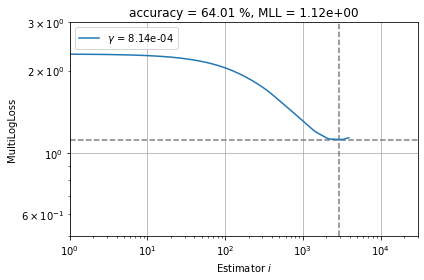

In [83]:
# plot loss development
hfLoss=plt.figure('Loss_vs_Epoch')
hfLoss.clf()
plt.title("accuracy = {:.2f} %, MLL = {:.2e}".format(100*score,clf.best_score_['valid_0']['multi_logloss']))
axLoss=hfLoss.add_subplot(111)
plt.axhline(clf.best_score_['valid_0']['multi_logloss'], color = 'gray', linestyle='dashed',linewidth = 1.5)
plt.axvline(clf.best_iteration_, color = 'gray', linestyle='dashed',linewidth = 1.5)
axLoss.plot(clf.evals_result_['valid_0']['multi_logloss'], label='$\gamma$ = {:.2e}'.format(clf.learning_rate))
plt.ylim([0.5,3])
plt.xlim([1,params['n_estimators']])
plt.ylabel('MultiLogLoss')
plt.xlabel('Estimator $i$')
# plt.semilogy()
plt.loglog()
axLoss.legend(loc='best')
plt.tight_layout()

plt.grid()
clf.get_params()

In [72]:
#### clf.learning_rate

In [14]:
# hyper parameter optimization 
# distributions = {
#                 'learning_rate':np.geomspace(1e-5,0.2,100), 
#                 'num_leaves':poisson(8),
#                 'max_depth': poisson(8)
#                 }


# GridSearchParameters = {'learning_rate':np.geomspace(9e-5,0.2,8), 'num_leaves':np.array([5,7,9,11,13]),'max_depth':np.array([6,8,10,12])}
# GridSearchClf = GridSearchCV(clf,GridSearchParameters,scoring='neg_log_loss', verbose=1, n_jobs=-1)
# GridSearchResults = GridSearchClf.fit(X_train, y_train, eval_set =[(X_val,y_val)],early_stopping_rounds = NstopRound)

# print(distributions['learning_rate'])
# distributions['learning_rate']

# scorer = make_scorer(log_loss, labels = [0,1,2,3,4,5,6,7,8,9])
# RanSearchclf = RandomizedSearchCV(clf, distributions, random_state=3,n_iter=NIters, scoring='neg_log_loss', verbose=1, n_jobs=-1)
# RanSearchResult = RanSearchclf.fit(X_train, y_train, eval_set =[(X_val,y_val)],early_stopping_rounds = NstopRound)



%notify -m "Hyper Parameter optimization done!"

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 116.3min
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 248.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 285.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 293.1min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed: 293.2min finished


[1]	valid_0's multi_logloss: 2.3015
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's multi_logloss: 2.29839
[3]	valid_0's multi_logloss: 2.29534
[4]	valid_0's multi_logloss: 2.2923
[5]	valid_0's multi_logloss: 2.2892
[6]	valid_0's multi_logloss: 2.28617
[7]	valid_0's multi_logloss: 2.28313
[8]	valid_0's multi_logloss: 2.28026
[9]	valid_0's multi_logloss: 2.27738
[10]	valid_0's multi_logloss: 2.27447
[11]	valid_0's multi_logloss: 2.27154
[12]	valid_0's multi_logloss: 2.26887
[13]	valid_0's multi_logloss: 2.26593
[14]	valid_0's multi_logloss: 2.26321
[15]	valid_0's multi_logloss: 2.26033
[16]	valid_0's multi_logloss: 2.25764
[17]	valid_0's multi_logloss: 2.25487
[18]	valid_0's multi_logloss: 2.25215
[19]	valid_0's multi_logloss: 2.24943
[20]	valid_0's multi_logloss: 2.24675
[21]	valid_0's multi_logloss: 2.24399
[22]	valid_0's multi_logloss: 2.24144
[23]	valid_0's multi_logloss: 2.23882
[24]	valid_0's multi_logloss: 2.2362
[25]	valid_0's multi_logloss: 2.23366


[242]	valid_0's multi_logloss: 1.84994
[243]	valid_0's multi_logloss: 1.84863
[244]	valid_0's multi_logloss: 1.84725
[245]	valid_0's multi_logloss: 1.84585
[246]	valid_0's multi_logloss: 1.84459
[247]	valid_0's multi_logloss: 1.84327
[248]	valid_0's multi_logloss: 1.84192
[249]	valid_0's multi_logloss: 1.84051
[250]	valid_0's multi_logloss: 1.83919
[251]	valid_0's multi_logloss: 1.83781
[252]	valid_0's multi_logloss: 1.8365
[253]	valid_0's multi_logloss: 1.83518
[254]	valid_0's multi_logloss: 1.83386
[255]	valid_0's multi_logloss: 1.83254
[256]	valid_0's multi_logloss: 1.83119
[257]	valid_0's multi_logloss: 1.82982
[258]	valid_0's multi_logloss: 1.82838
[259]	valid_0's multi_logloss: 1.8271
[260]	valid_0's multi_logloss: 1.8257
[261]	valid_0's multi_logloss: 1.82438
[262]	valid_0's multi_logloss: 1.82318
[263]	valid_0's multi_logloss: 1.82186
[264]	valid_0's multi_logloss: 1.82052
[265]	valid_0's multi_logloss: 1.8192
[266]	valid_0's multi_logloss: 1.81794
[267]	valid_0's multi_logloss

[461]	valid_0's multi_logloss: 1.61654
[462]	valid_0's multi_logloss: 1.61558
[463]	valid_0's multi_logloss: 1.61473
[464]	valid_0's multi_logloss: 1.61385
[465]	valid_0's multi_logloss: 1.61302
[466]	valid_0's multi_logloss: 1.61214
[467]	valid_0's multi_logloss: 1.61126
[468]	valid_0's multi_logloss: 1.61034
[469]	valid_0's multi_logloss: 1.60953
[470]	valid_0's multi_logloss: 1.60872
[471]	valid_0's multi_logloss: 1.60782
[472]	valid_0's multi_logloss: 1.60693
[473]	valid_0's multi_logloss: 1.60604
[474]	valid_0's multi_logloss: 1.60513
[475]	valid_0's multi_logloss: 1.60425
[476]	valid_0's multi_logloss: 1.60337
[477]	valid_0's multi_logloss: 1.60245
[478]	valid_0's multi_logloss: 1.60156
[479]	valid_0's multi_logloss: 1.60067
[480]	valid_0's multi_logloss: 1.59978
[481]	valid_0's multi_logloss: 1.59887
[482]	valid_0's multi_logloss: 1.59796
[483]	valid_0's multi_logloss: 1.59707
[484]	valid_0's multi_logloss: 1.59618
[485]	valid_0's multi_logloss: 1.59524
[486]	valid_0's multi_log

[683]	valid_0's multi_logloss: 1.44386
[684]	valid_0's multi_logloss: 1.44319
[685]	valid_0's multi_logloss: 1.44258
[686]	valid_0's multi_logloss: 1.44194
[687]	valid_0's multi_logloss: 1.44127
[688]	valid_0's multi_logloss: 1.44071
[689]	valid_0's multi_logloss: 1.44002
[690]	valid_0's multi_logloss: 1.43942
[691]	valid_0's multi_logloss: 1.43883
[692]	valid_0's multi_logloss: 1.43813
[693]	valid_0's multi_logloss: 1.43753
[694]	valid_0's multi_logloss: 1.43688
[695]	valid_0's multi_logloss: 1.43616
[696]	valid_0's multi_logloss: 1.43549
[697]	valid_0's multi_logloss: 1.4349
[698]	valid_0's multi_logloss: 1.43424
[699]	valid_0's multi_logloss: 1.43362
[700]	valid_0's multi_logloss: 1.43306
[701]	valid_0's multi_logloss: 1.43235
[702]	valid_0's multi_logloss: 1.43164
[703]	valid_0's multi_logloss: 1.431
[704]	valid_0's multi_logloss: 1.43033
[705]	valid_0's multi_logloss: 1.42968
[706]	valid_0's multi_logloss: 1.429
[707]	valid_0's multi_logloss: 1.42826
[708]	valid_0's multi_logloss:

[907]	valid_0's multi_logloss: 1.31838
[908]	valid_0's multi_logloss: 1.31791
[909]	valid_0's multi_logloss: 1.3174
[910]	valid_0's multi_logloss: 1.31702
[911]	valid_0's multi_logloss: 1.31653
[912]	valid_0's multi_logloss: 1.3161
[913]	valid_0's multi_logloss: 1.31563
[914]	valid_0's multi_logloss: 1.31521
[915]	valid_0's multi_logloss: 1.31476
[916]	valid_0's multi_logloss: 1.31428
[917]	valid_0's multi_logloss: 1.3139
[918]	valid_0's multi_logloss: 1.31347
[919]	valid_0's multi_logloss: 1.31298
[920]	valid_0's multi_logloss: 1.31252
[921]	valid_0's multi_logloss: 1.31206
[922]	valid_0's multi_logloss: 1.3116
[923]	valid_0's multi_logloss: 1.31119
[924]	valid_0's multi_logloss: 1.31074
[925]	valid_0's multi_logloss: 1.31025
[926]	valid_0's multi_logloss: 1.30985
[927]	valid_0's multi_logloss: 1.3094
[928]	valid_0's multi_logloss: 1.30895
[929]	valid_0's multi_logloss: 1.30854
[930]	valid_0's multi_logloss: 1.30815
[931]	valid_0's multi_logloss: 1.30776
[932]	valid_0's multi_logloss:

[1125]	valid_0's multi_logloss: 1.23355
[1126]	valid_0's multi_logloss: 1.23325
[1127]	valid_0's multi_logloss: 1.23283
[1128]	valid_0's multi_logloss: 1.23253
[1129]	valid_0's multi_logloss: 1.23217
[1130]	valid_0's multi_logloss: 1.23181
[1131]	valid_0's multi_logloss: 1.23151
[1132]	valid_0's multi_logloss: 1.23118
[1133]	valid_0's multi_logloss: 1.23078
[1134]	valid_0's multi_logloss: 1.23049
[1135]	valid_0's multi_logloss: 1.23009
[1136]	valid_0's multi_logloss: 1.22973
[1137]	valid_0's multi_logloss: 1.22934
[1138]	valid_0's multi_logloss: 1.229
[1139]	valid_0's multi_logloss: 1.22865
[1140]	valid_0's multi_logloss: 1.22833
[1141]	valid_0's multi_logloss: 1.228
[1142]	valid_0's multi_logloss: 1.22756
[1143]	valid_0's multi_logloss: 1.22729
[1144]	valid_0's multi_logloss: 1.2269
[1145]	valid_0's multi_logloss: 1.22657
[1146]	valid_0's multi_logloss: 1.22618
[1147]	valid_0's multi_logloss: 1.22584
[1148]	valid_0's multi_logloss: 1.2255
[1149]	valid_0's multi_logloss: 1.2251
[1150]	

[1344]	valid_0's multi_logloss: 1.16098
[1345]	valid_0's multi_logloss: 1.16065
[1346]	valid_0's multi_logloss: 1.16033
[1347]	valid_0's multi_logloss: 1.15996
[1348]	valid_0's multi_logloss: 1.15964
[1349]	valid_0's multi_logloss: 1.15928
[1350]	valid_0's multi_logloss: 1.15901
[1351]	valid_0's multi_logloss: 1.15864
[1352]	valid_0's multi_logloss: 1.15829
[1353]	valid_0's multi_logloss: 1.15794
[1354]	valid_0's multi_logloss: 1.15763
[1355]	valid_0's multi_logloss: 1.15729
[1356]	valid_0's multi_logloss: 1.15698
[1357]	valid_0's multi_logloss: 1.1566
[1358]	valid_0's multi_logloss: 1.15627
[1359]	valid_0's multi_logloss: 1.156
[1360]	valid_0's multi_logloss: 1.1557
[1361]	valid_0's multi_logloss: 1.15536
[1362]	valid_0's multi_logloss: 1.15504
[1363]	valid_0's multi_logloss: 1.15469
[1364]	valid_0's multi_logloss: 1.15437
[1365]	valid_0's multi_logloss: 1.15406
[1366]	valid_0's multi_logloss: 1.15374
[1367]	valid_0's multi_logloss: 1.15339
[1368]	valid_0's multi_logloss: 1.15309
[136

[1559]	valid_0's multi_logloss: 1.10222
[1560]	valid_0's multi_logloss: 1.102
[1561]	valid_0's multi_logloss: 1.10181
[1562]	valid_0's multi_logloss: 1.10158
[1563]	valid_0's multi_logloss: 1.10134
[1564]	valid_0's multi_logloss: 1.10114
[1565]	valid_0's multi_logloss: 1.10087
[1566]	valid_0's multi_logloss: 1.10068
[1567]	valid_0's multi_logloss: 1.10047
[1568]	valid_0's multi_logloss: 1.10026
[1569]	valid_0's multi_logloss: 1.10004
[1570]	valid_0's multi_logloss: 1.09986
[1571]	valid_0's multi_logloss: 1.0996
[1572]	valid_0's multi_logloss: 1.09937
[1573]	valid_0's multi_logloss: 1.09914
[1574]	valid_0's multi_logloss: 1.09887
[1575]	valid_0's multi_logloss: 1.09869
[1576]	valid_0's multi_logloss: 1.09842
[1577]	valid_0's multi_logloss: 1.09826
[1578]	valid_0's multi_logloss: 1.09803
[1579]	valid_0's multi_logloss: 1.09782
[1580]	valid_0's multi_logloss: 1.09758
[1581]	valid_0's multi_logloss: 1.09736
[1582]	valid_0's multi_logloss: 1.09718
[1583]	valid_0's multi_logloss: 1.09694
[15

[1773]	valid_0's multi_logloss: 1.06207
[1774]	valid_0's multi_logloss: 1.06189
[1775]	valid_0's multi_logloss: 1.06174
[1776]	valid_0's multi_logloss: 1.06154
[1777]	valid_0's multi_logloss: 1.0614
[1778]	valid_0's multi_logloss: 1.06125
[1779]	valid_0's multi_logloss: 1.06104
[1780]	valid_0's multi_logloss: 1.06087
[1781]	valid_0's multi_logloss: 1.06067
[1782]	valid_0's multi_logloss: 1.06049
[1783]	valid_0's multi_logloss: 1.06027
[1784]	valid_0's multi_logloss: 1.06013
[1785]	valid_0's multi_logloss: 1.05993
[1786]	valid_0's multi_logloss: 1.05978
[1787]	valid_0's multi_logloss: 1.05961
[1788]	valid_0's multi_logloss: 1.05943
[1789]	valid_0's multi_logloss: 1.05923
[1790]	valid_0's multi_logloss: 1.05905
[1791]	valid_0's multi_logloss: 1.05892
[1792]	valid_0's multi_logloss: 1.0587
[1793]	valid_0's multi_logloss: 1.05848
[1794]	valid_0's multi_logloss: 1.05832
[1795]	valid_0's multi_logloss: 1.05814
[1796]	valid_0's multi_logloss: 1.058
[1797]	valid_0's multi_logloss: 1.05781
[179

[1985]	valid_0's multi_logloss: 1.03073
[1986]	valid_0's multi_logloss: 1.0306
[1987]	valid_0's multi_logloss: 1.03049
[1988]	valid_0's multi_logloss: 1.03036
[1989]	valid_0's multi_logloss: 1.03023
[1990]	valid_0's multi_logloss: 1.03009
[1991]	valid_0's multi_logloss: 1.02993
[1992]	valid_0's multi_logloss: 1.02979
[1993]	valid_0's multi_logloss: 1.02968
[1994]	valid_0's multi_logloss: 1.02955
[1995]	valid_0's multi_logloss: 1.02946
[1996]	valid_0's multi_logloss: 1.02936
[1997]	valid_0's multi_logloss: 1.02922
[1998]	valid_0's multi_logloss: 1.02914
[1999]	valid_0's multi_logloss: 1.02903
[2000]	valid_0's multi_logloss: 1.02893
[2001]	valid_0's multi_logloss: 1.02882
[2002]	valid_0's multi_logloss: 1.02869
[2003]	valid_0's multi_logloss: 1.02859
[2004]	valid_0's multi_logloss: 1.02848
[2005]	valid_0's multi_logloss: 1.02839
[2006]	valid_0's multi_logloss: 1.02822
[2007]	valid_0's multi_logloss: 1.02812
[2008]	valid_0's multi_logloss: 1.028
[2009]	valid_0's multi_logloss: 1.02789
[20

[2203]	valid_0's multi_logloss: 1.00445
[2204]	valid_0's multi_logloss: 1.00434
[2205]	valid_0's multi_logloss: 1.00417
[2206]	valid_0's multi_logloss: 1.00408
[2207]	valid_0's multi_logloss: 1.00399
[2208]	valid_0's multi_logloss: 1.00381
[2209]	valid_0's multi_logloss: 1.00375
[2210]	valid_0's multi_logloss: 1.00366
[2211]	valid_0's multi_logloss: 1.00349
[2212]	valid_0's multi_logloss: 1.00336
[2213]	valid_0's multi_logloss: 1.00326
[2214]	valid_0's multi_logloss: 1.00313
[2215]	valid_0's multi_logloss: 1.00303
[2216]	valid_0's multi_logloss: 1.00298
[2217]	valid_0's multi_logloss: 1.00285
[2218]	valid_0's multi_logloss: 1.00275
[2219]	valid_0's multi_logloss: 1.00262
[2220]	valid_0's multi_logloss: 1.00248
[2221]	valid_0's multi_logloss: 1.00235
[2222]	valid_0's multi_logloss: 1.00225
[2223]	valid_0's multi_logloss: 1.00212
[2224]	valid_0's multi_logloss: 1.00203
[2225]	valid_0's multi_logloss: 1.00195
[2226]	valid_0's multi_logloss: 1.00183
[2227]	valid_0's multi_logloss: 1.0017
[

[2417]	valid_0's multi_logloss: 0.984797
[2418]	valid_0's multi_logloss: 0.984734
[2419]	valid_0's multi_logloss: 0.98467
[2420]	valid_0's multi_logloss: 0.98457
[2421]	valid_0's multi_logloss: 0.984515
[2422]	valid_0's multi_logloss: 0.984485
[2423]	valid_0's multi_logloss: 0.984405
[2424]	valid_0's multi_logloss: 0.984323
[2425]	valid_0's multi_logloss: 0.984259
[2426]	valid_0's multi_logloss: 0.984191
[2427]	valid_0's multi_logloss: 0.984105
[2428]	valid_0's multi_logloss: 0.98401
[2429]	valid_0's multi_logloss: 0.983935
[2430]	valid_0's multi_logloss: 0.983878
[2431]	valid_0's multi_logloss: 0.983759
[2432]	valid_0's multi_logloss: 0.98365
[2433]	valid_0's multi_logloss: 0.983588
[2434]	valid_0's multi_logloss: 0.983541
[2435]	valid_0's multi_logloss: 0.983395
[2436]	valid_0's multi_logloss: 0.983286
[2437]	valid_0's multi_logloss: 0.983238
[2438]	valid_0's multi_logloss: 0.983142
[2439]	valid_0's multi_logloss: 0.983082
[2440]	valid_0's multi_logloss: 0.983007
[2441]	valid_0's mul

[2631]	valid_0's multi_logloss: 0.968646
[2632]	valid_0's multi_logloss: 0.968556
[2633]	valid_0's multi_logloss: 0.968487
[2634]	valid_0's multi_logloss: 0.968423
[2635]	valid_0's multi_logloss: 0.968398
[2636]	valid_0's multi_logloss: 0.968321
[2637]	valid_0's multi_logloss: 0.968247
[2638]	valid_0's multi_logloss: 0.968185
[2639]	valid_0's multi_logloss: 0.968064
[2640]	valid_0's multi_logloss: 0.967992
[2641]	valid_0's multi_logloss: 0.967918
[2642]	valid_0's multi_logloss: 0.96779
[2643]	valid_0's multi_logloss: 0.967688
[2644]	valid_0's multi_logloss: 0.967618
[2645]	valid_0's multi_logloss: 0.967548
[2646]	valid_0's multi_logloss: 0.967488
[2647]	valid_0's multi_logloss: 0.967404
[2648]	valid_0's multi_logloss: 0.967331
[2649]	valid_0's multi_logloss: 0.967203
[2650]	valid_0's multi_logloss: 0.967185
[2651]	valid_0's multi_logloss: 0.967131
[2652]	valid_0's multi_logloss: 0.967057
[2653]	valid_0's multi_logloss: 0.966928
[2654]	valid_0's multi_logloss: 0.966868
[2655]	valid_0's 

[2838]	valid_0's multi_logloss: 0.956933
[2839]	valid_0's multi_logloss: 0.956864
[2840]	valid_0's multi_logloss: 0.956801
[2841]	valid_0's multi_logloss: 0.956739
[2842]	valid_0's multi_logloss: 0.956685
[2843]	valid_0's multi_logloss: 0.956621
[2844]	valid_0's multi_logloss: 0.956554
[2845]	valid_0's multi_logloss: 0.956556
[2846]	valid_0's multi_logloss: 0.956533
[2847]	valid_0's multi_logloss: 0.956424
[2848]	valid_0's multi_logloss: 0.956361
[2849]	valid_0's multi_logloss: 0.956321
[2850]	valid_0's multi_logloss: 0.956259
[2851]	valid_0's multi_logloss: 0.956218
[2852]	valid_0's multi_logloss: 0.956154
[2853]	valid_0's multi_logloss: 0.956066
[2854]	valid_0's multi_logloss: 0.956095
[2855]	valid_0's multi_logloss: 0.956046
[2856]	valid_0's multi_logloss: 0.956012
[2857]	valid_0's multi_logloss: 0.955931
[2858]	valid_0's multi_logloss: 0.955858
[2859]	valid_0's multi_logloss: 0.955819
[2860]	valid_0's multi_logloss: 0.955764
[2861]	valid_0's multi_logloss: 0.955704
[2862]	valid_0's

[3051]	valid_0's multi_logloss: 0.945786
[3052]	valid_0's multi_logloss: 0.945729
[3053]	valid_0's multi_logloss: 0.945663
[3054]	valid_0's multi_logloss: 0.945592
[3055]	valid_0's multi_logloss: 0.945529
[3056]	valid_0's multi_logloss: 0.945536
[3057]	valid_0's multi_logloss: 0.945459
[3058]	valid_0's multi_logloss: 0.945388
[3059]	valid_0's multi_logloss: 0.945363
[3060]	valid_0's multi_logloss: 0.945296
[3061]	valid_0's multi_logloss: 0.945265
[3062]	valid_0's multi_logloss: 0.945209
[3063]	valid_0's multi_logloss: 0.945155
[3064]	valid_0's multi_logloss: 0.945107
[3065]	valid_0's multi_logloss: 0.945049
[3066]	valid_0's multi_logloss: 0.945007
[3067]	valid_0's multi_logloss: 0.94495
[3068]	valid_0's multi_logloss: 0.944937
[3069]	valid_0's multi_logloss: 0.944898
[3070]	valid_0's multi_logloss: 0.94483
[3071]	valid_0's multi_logloss: 0.944761
[3072]	valid_0's multi_logloss: 0.944704
[3073]	valid_0's multi_logloss: 0.944642
[3074]	valid_0's multi_logloss: 0.944572
[3075]	valid_0's m

[3259]	valid_0's multi_logloss: 0.939029
[3260]	valid_0's multi_logloss: 0.939022
[3261]	valid_0's multi_logloss: 0.939022
[3262]	valid_0's multi_logloss: 0.938976
[3263]	valid_0's multi_logloss: 0.938957
[3264]	valid_0's multi_logloss: 0.938912
[3265]	valid_0's multi_logloss: 0.938873
[3266]	valid_0's multi_logloss: 0.938832
[3267]	valid_0's multi_logloss: 0.938785
[3268]	valid_0's multi_logloss: 0.938784
[3269]	valid_0's multi_logloss: 0.938774
[3270]	valid_0's multi_logloss: 0.938759
[3271]	valid_0's multi_logloss: 0.93873
[3272]	valid_0's multi_logloss: 0.938723
[3273]	valid_0's multi_logloss: 0.938681
[3274]	valid_0's multi_logloss: 0.93865
[3275]	valid_0's multi_logloss: 0.938594
[3276]	valid_0's multi_logloss: 0.938565
[3277]	valid_0's multi_logloss: 0.938493
[3278]	valid_0's multi_logloss: 0.938432
[3279]	valid_0's multi_logloss: 0.938405
[3280]	valid_0's multi_logloss: 0.938401
[3281]	valid_0's multi_logloss: 0.938336
[3282]	valid_0's multi_logloss: 0.938278
[3283]	valid_0's m

[3471]	valid_0's multi_logloss: 0.934853
[3472]	valid_0's multi_logloss: 0.934794
[3473]	valid_0's multi_logloss: 0.934748
[3474]	valid_0's multi_logloss: 0.93476
[3475]	valid_0's multi_logloss: 0.934752
[3476]	valid_0's multi_logloss: 0.934784
[3477]	valid_0's multi_logloss: 0.934789
[3478]	valid_0's multi_logloss: 0.934759
[3479]	valid_0's multi_logloss: 0.934779
[3480]	valid_0's multi_logloss: 0.934781
[3481]	valid_0's multi_logloss: 0.934721
[3482]	valid_0's multi_logloss: 0.934687
[3483]	valid_0's multi_logloss: 0.93463
[3484]	valid_0's multi_logloss: 0.934648
[3485]	valid_0's multi_logloss: 0.934656
[3486]	valid_0's multi_logloss: 0.934654
[3487]	valid_0's multi_logloss: 0.934614
[3488]	valid_0's multi_logloss: 0.934611
[3489]	valid_0's multi_logloss: 0.934577
[3490]	valid_0's multi_logloss: 0.93455
[3491]	valid_0's multi_logloss: 0.934582
[3492]	valid_0's multi_logloss: 0.934569
[3493]	valid_0's multi_logloss: 0.934574
[3494]	valid_0's multi_logloss: 0.93459
[3495]	valid_0's mul

[3678]	valid_0's multi_logloss: 0.929944
[3679]	valid_0's multi_logloss: 0.929912
[3680]	valid_0's multi_logloss: 0.92989
[3681]	valid_0's multi_logloss: 0.929888
[3682]	valid_0's multi_logloss: 0.929903
[3683]	valid_0's multi_logloss: 0.929904
[3684]	valid_0's multi_logloss: 0.929867
[3685]	valid_0's multi_logloss: 0.929848
[3686]	valid_0's multi_logloss: 0.929791
[3687]	valid_0's multi_logloss: 0.929789
[3688]	valid_0's multi_logloss: 0.929785
[3689]	valid_0's multi_logloss: 0.929784
[3690]	valid_0's multi_logloss: 0.929716
[3691]	valid_0's multi_logloss: 0.929666
[3692]	valid_0's multi_logloss: 0.929719
[3693]	valid_0's multi_logloss: 0.929703
[3694]	valid_0's multi_logloss: 0.929648
[3695]	valid_0's multi_logloss: 0.929641
[3696]	valid_0's multi_logloss: 0.929636
[3697]	valid_0's multi_logloss: 0.929644
[3698]	valid_0's multi_logloss: 0.929637
[3699]	valid_0's multi_logloss: 0.929626
[3700]	valid_0's multi_logloss: 0.929582
[3701]	valid_0's multi_logloss: 0.929534
[3702]	valid_0's 

[3890]	valid_0's multi_logloss: 0.929304
[3891]	valid_0's multi_logloss: 0.929254
[3892]	valid_0's multi_logloss: 0.929221
[3893]	valid_0's multi_logloss: 0.929186
[3894]	valid_0's multi_logloss: 0.929217
[3895]	valid_0's multi_logloss: 0.929164
[3896]	valid_0's multi_logloss: 0.929144
[3897]	valid_0's multi_logloss: 0.929143
[3898]	valid_0's multi_logloss: 0.929065
[3899]	valid_0's multi_logloss: 0.929097
[3900]	valid_0's multi_logloss: 0.929071
[3901]	valid_0's multi_logloss: 0.929028
[3902]	valid_0's multi_logloss: 0.928958
[3903]	valid_0's multi_logloss: 0.928974
[3904]	valid_0's multi_logloss: 0.929
[3905]	valid_0's multi_logloss: 0.928908
[3906]	valid_0's multi_logloss: 0.928857
[3907]	valid_0's multi_logloss: 0.928931
[3908]	valid_0's multi_logloss: 0.928925
[3909]	valid_0's multi_logloss: 0.928886
[3910]	valid_0's multi_logloss: 0.928834
[3911]	valid_0's multi_logloss: 0.928838
[3912]	valid_0's multi_logloss: 0.928833
[3913]	valid_0's multi_logloss: 0.928849
[3914]	valid_0's mu

[4092]	valid_0's multi_logloss: 0.929303
[4093]	valid_0's multi_logloss: 0.929314
[4094]	valid_0's multi_logloss: 0.929233
[4095]	valid_0's multi_logloss: 0.929251
[4096]	valid_0's multi_logloss: 0.92923
[4097]	valid_0's multi_logloss: 0.929225
[4098]	valid_0's multi_logloss: 0.929237
[4099]	valid_0's multi_logloss: 0.929238
[4100]	valid_0's multi_logloss: 0.929232
[4101]	valid_0's multi_logloss: 0.929225
[4102]	valid_0's multi_logloss: 0.929192
[4103]	valid_0's multi_logloss: 0.929184
[4104]	valid_0's multi_logloss: 0.929212
[4105]	valid_0's multi_logloss: 0.929184
[4106]	valid_0's multi_logloss: 0.92923
[4107]	valid_0's multi_logloss: 0.929294
[4108]	valid_0's multi_logloss: 0.929299
[4109]	valid_0's multi_logloss: 0.929215
[4110]	valid_0's multi_logloss: 0.929251
[4111]	valid_0's multi_logloss: 0.929253
[4112]	valid_0's multi_logloss: 0.929198
[4113]	valid_0's multi_logloss: 0.929224
[4114]	valid_0's multi_logloss: 0.929235
[4115]	valid_0's multi_logloss: 0.929205
[4116]	valid_0's m

[4327]	valid_0's multi_logloss: 0.926893
[4328]	valid_0's multi_logloss: 0.926914
[4329]	valid_0's multi_logloss: 0.9269
[4330]	valid_0's multi_logloss: 0.926914
[4331]	valid_0's multi_logloss: 0.926891
[4332]	valid_0's multi_logloss: 0.926816
[4333]	valid_0's multi_logloss: 0.926842
[4334]	valid_0's multi_logloss: 0.926833
[4335]	valid_0's multi_logloss: 0.926841
[4336]	valid_0's multi_logloss: 0.9268
[4337]	valid_0's multi_logloss: 0.926829
[4338]	valid_0's multi_logloss: 0.926817
[4339]	valid_0's multi_logloss: 0.926775
[4340]	valid_0's multi_logloss: 0.926838
[4341]	valid_0's multi_logloss: 0.926811
[4342]	valid_0's multi_logloss: 0.926783
[4343]	valid_0's multi_logloss: 0.92674
[4344]	valid_0's multi_logloss: 0.926703
[4345]	valid_0's multi_logloss: 0.926715
[4346]	valid_0's multi_logloss: 0.926768
[4347]	valid_0's multi_logloss: 0.926756
[4348]	valid_0's multi_logloss: 0.926755
[4349]	valid_0's multi_logloss: 0.926744
[4350]	valid_0's multi_logloss: 0.926782
[4351]	valid_0's mult

[4571]	valid_0's multi_logloss: 0.926693
[4572]	valid_0's multi_logloss: 0.926702
[4573]	valid_0's multi_logloss: 0.926729
[4574]	valid_0's multi_logloss: 0.926708
[4575]	valid_0's multi_logloss: 0.926722
[4576]	valid_0's multi_logloss: 0.926763
[4577]	valid_0's multi_logloss: 0.92679
[4578]	valid_0's multi_logloss: 0.926779
[4579]	valid_0's multi_logloss: 0.92683
[4580]	valid_0's multi_logloss: 0.926794
[4581]	valid_0's multi_logloss: 0.926807
[4582]	valid_0's multi_logloss: 0.926808
[4583]	valid_0's multi_logloss: 0.926843
[4584]	valid_0's multi_logloss: 0.926865
[4585]	valid_0's multi_logloss: 0.926868
[4586]	valid_0's multi_logloss: 0.926889
[4587]	valid_0's multi_logloss: 0.926886
[4588]	valid_0's multi_logloss: 0.926919
[4589]	valid_0's multi_logloss: 0.926916
[4590]	valid_0's multi_logloss: 0.926911
[4591]	valid_0's multi_logloss: 0.926983
[4592]	valid_0's multi_logloss: 0.927
[4593]	valid_0's multi_logloss: 0.92702
[4594]	valid_0's multi_logloss: 0.927039
[4595]	valid_0's multi

[4791]	valid_0's multi_logloss: 0.930044
[4792]	valid_0's multi_logloss: 0.93005
[4793]	valid_0's multi_logloss: 0.930052
[4794]	valid_0's multi_logloss: 0.930099
[4795]	valid_0's multi_logloss: 0.930098
[4796]	valid_0's multi_logloss: 0.930141
[4797]	valid_0's multi_logloss: 0.930123
[4798]	valid_0's multi_logloss: 0.930181
[4799]	valid_0's multi_logloss: 0.930146
[4800]	valid_0's multi_logloss: 0.930149
[4801]	valid_0's multi_logloss: 0.930125
[4802]	valid_0's multi_logloss: 0.930149
[4803]	valid_0's multi_logloss: 0.930179
[4804]	valid_0's multi_logloss: 0.930193
[4805]	valid_0's multi_logloss: 0.930152
[4806]	valid_0's multi_logloss: 0.930135
[4807]	valid_0's multi_logloss: 0.930109
[4808]	valid_0's multi_logloss: 0.930121
[4809]	valid_0's multi_logloss: 0.930118
[4810]	valid_0's multi_logloss: 0.930139
[4811]	valid_0's multi_logloss: 0.930204
[4812]	valid_0's multi_logloss: 0.930236
[4813]	valid_0's multi_logloss: 0.930204
[4814]	valid_0's multi_logloss: 0.930203
[4815]	valid_0's 

[5021]	valid_0's multi_logloss: 0.931376
[5022]	valid_0's multi_logloss: 0.931411
[5023]	valid_0's multi_logloss: 0.931421
[5024]	valid_0's multi_logloss: 0.931463
[5025]	valid_0's multi_logloss: 0.93145
[5026]	valid_0's multi_logloss: 0.931509
[5027]	valid_0's multi_logloss: 0.931527
[5028]	valid_0's multi_logloss: 0.931511
[5029]	valid_0's multi_logloss: 0.931542
[5030]	valid_0's multi_logloss: 0.931517
[5031]	valid_0's multi_logloss: 0.931563
[5032]	valid_0's multi_logloss: 0.931565
[5033]	valid_0's multi_logloss: 0.931585
[5034]	valid_0's multi_logloss: 0.931632
[5035]	valid_0's multi_logloss: 0.931608
[5036]	valid_0's multi_logloss: 0.931625
[5037]	valid_0's multi_logloss: 0.931673
[5038]	valid_0's multi_logloss: 0.93167
[5039]	valid_0's multi_logloss: 0.931673
[5040]	valid_0's multi_logloss: 0.93169
[5041]	valid_0's multi_logloss: 0.931746
[5042]	valid_0's multi_logloss: 0.931772
[5043]	valid_0's multi_logloss: 0.931818
[5044]	valid_0's multi_logloss: 0.931791
[5045]	valid_0's mu

[5256]	valid_0's multi_logloss: 0.935649
[5257]	valid_0's multi_logloss: 0.935677
[5258]	valid_0's multi_logloss: 0.935679
[5259]	valid_0's multi_logloss: 0.93572
[5260]	valid_0's multi_logloss: 0.935713
[5261]	valid_0's multi_logloss: 0.93575
[5262]	valid_0's multi_logloss: 0.935774
[5263]	valid_0's multi_logloss: 0.935777
[5264]	valid_0's multi_logloss: 0.935805
[5265]	valid_0's multi_logloss: 0.935852
[5266]	valid_0's multi_logloss: 0.935845
[5267]	valid_0's multi_logloss: 0.93586
[5268]	valid_0's multi_logloss: 0.935886
[5269]	valid_0's multi_logloss: 0.935893
[5270]	valid_0's multi_logloss: 0.935898
[5271]	valid_0's multi_logloss: 0.935897
[5272]	valid_0's multi_logloss: 0.935926
[5273]	valid_0's multi_logloss: 0.935957
[5274]	valid_0's multi_logloss: 0.936006
[5275]	valid_0's multi_logloss: 0.936018
[5276]	valid_0's multi_logloss: 0.936017
[5277]	valid_0's multi_logloss: 0.936054
[5278]	valid_0's multi_logloss: 0.936084
[5279]	valid_0's multi_logloss: 0.936121
[5280]	valid_0's mu

<IPython.core.display.Javascript object>

1.0263739252504815
{'learning_rate': 0.0008137059759269703, 'max_depth': 6, 'num_leaves': 9}
(160,)


array([-1.08038576, -1.05738292, -1.04965152, -1.05498444, -1.05838031,
       -1.08038576, -1.05738292, -1.05365599, -1.05419996, -1.04963105,
       -1.08038576, -1.05738292, -1.05365599, -1.05683836, -1.05469126,
       -1.08038576, -1.05738292, -1.05365599, -1.05683836, -1.05309129,
       -1.03751186, -1.03477147, -1.03520414, -1.03861092, -1.0437786 ,
       -1.03751186, -1.03477147, -1.04244922, -1.04369064, -1.04874872,
       -1.03751186, -1.03477147, -1.04244922, -1.04345883, -1.04425795,
       -1.03751186, -1.03477147, -1.04244922, -1.04345883, -1.04900985,
       -1.0366054 , -1.03788763, -1.02637393, -1.0397833 , -1.03945252,
       -1.0366054 , -1.03788763, -1.03615953, -1.04220457, -1.04830686,
       -1.0366054 , -1.03788763, -1.03615953, -1.05041166, -1.05059575,
       -1.0366054 , -1.03788763, -1.03615953, -1.05041166, -1.05089826,
       -1.03343729, -1.03635192, -1.03458719, -1.04109369, -1.04587487,
       -1.03343729, -1.03635192, -1.03777476, -1.03919068, -1.04

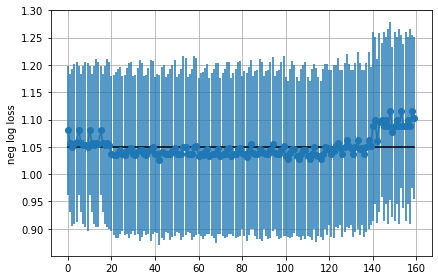

In [16]:
GridSearchResult=GridSearchResults
print(-1*GridSearchResult.best_score_)
print(GridSearchResult.best_params_)
print(np.shape(GridSearchResult.cv_results_['mean_test_score']))
plt.figure()

# plt.plot(-1*RanSearchResult.)

plt.errorbar(np.arange(0,160,1),-1*GridSearchResult.cv_results_['mean_test_score'], yerr=GridSearchResult.cv_results_['std_test_score']/np.sqrt(GridSearchResult.cv_results_),marker ='o')

plt.plot(np.arange(0,160,1),np.ones_like(GridSearchResult.cv_results_['mean_test_score'])*-1*np.mean(GridSearchResult.cv_results_['mean_test_score']),'k')

# plt.ylim([0,1])
plt.grid()
plt.tight_layout()
plt.ylabel('neg log loss')

GridSearchResult.cv_results_
GridSearchResult.cv_results_['mean_test_score']

In [17]:
# clf.set_params(**RanSearchResult.best_params_)
clf.set_params(**GridSearchResult.best_params_)
clf.fit(X_train, y_train, eval_set =[(X_val,y_val)], early_stopping_rounds=NstopRound)
y_pred_1=clf.predict(X_test)


scoref1 = f1_score(y_pred_1,y_test,average=None).mean()
score = precision_score(y_pred_1,y_test,average=None).mean()
print(score)
print(scoref1)
clf.get_params()

[1]	valid_0's multi_logloss: 2.3015
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's multi_logloss: 2.29839
[3]	valid_0's multi_logloss: 2.29534
[4]	valid_0's multi_logloss: 2.2923
[5]	valid_0's multi_logloss: 2.2892
[6]	valid_0's multi_logloss: 2.28617
[7]	valid_0's multi_logloss: 2.28313
[8]	valid_0's multi_logloss: 2.28026
[9]	valid_0's multi_logloss: 2.27738
[10]	valid_0's multi_logloss: 2.27447
[11]	valid_0's multi_logloss: 2.27154
[12]	valid_0's multi_logloss: 2.26887
[13]	valid_0's multi_logloss: 2.26593
[14]	valid_0's multi_logloss: 2.26321
[15]	valid_0's multi_logloss: 2.26033
[16]	valid_0's multi_logloss: 2.25764
[17]	valid_0's multi_logloss: 2.25487
[18]	valid_0's multi_logloss: 2.25215
[19]	valid_0's multi_logloss: 2.24943
[20]	valid_0's multi_logloss: 2.24675
[21]	valid_0's multi_logloss: 2.24399
[22]	valid_0's multi_logloss: 2.24144
[23]	valid_0's multi_logloss: 2.23882
[24]	valid_0's multi_logloss: 2.2362
[25]	valid_0's multi_logloss: 2.23366


[227]	valid_0's multi_logloss: 1.87009
[228]	valid_0's multi_logloss: 1.86882
[229]	valid_0's multi_logloss: 1.86745
[230]	valid_0's multi_logloss: 1.86617
[231]	valid_0's multi_logloss: 1.86491
[232]	valid_0's multi_logloss: 1.86354
[233]	valid_0's multi_logloss: 1.86209
[234]	valid_0's multi_logloss: 1.86072
[235]	valid_0's multi_logloss: 1.85936
[236]	valid_0's multi_logloss: 1.85804
[237]	valid_0's multi_logloss: 1.85667
[238]	valid_0's multi_logloss: 1.8553
[239]	valid_0's multi_logloss: 1.85394
[240]	valid_0's multi_logloss: 1.85264
[241]	valid_0's multi_logloss: 1.85123
[242]	valid_0's multi_logloss: 1.84994
[243]	valid_0's multi_logloss: 1.84863
[244]	valid_0's multi_logloss: 1.84725
[245]	valid_0's multi_logloss: 1.84585
[246]	valid_0's multi_logloss: 1.84459
[247]	valid_0's multi_logloss: 1.84327
[248]	valid_0's multi_logloss: 1.84192
[249]	valid_0's multi_logloss: 1.84051
[250]	valid_0's multi_logloss: 1.83919
[251]	valid_0's multi_logloss: 1.83781
[252]	valid_0's multi_logl

[455]	valid_0's multi_logloss: 1.6218
[456]	valid_0's multi_logloss: 1.62084
[457]	valid_0's multi_logloss: 1.62002
[458]	valid_0's multi_logloss: 1.61912
[459]	valid_0's multi_logloss: 1.61824
[460]	valid_0's multi_logloss: 1.61737
[461]	valid_0's multi_logloss: 1.61654
[462]	valid_0's multi_logloss: 1.61558
[463]	valid_0's multi_logloss: 1.61473
[464]	valid_0's multi_logloss: 1.61385
[465]	valid_0's multi_logloss: 1.61302
[466]	valid_0's multi_logloss: 1.61214
[467]	valid_0's multi_logloss: 1.61126
[468]	valid_0's multi_logloss: 1.61034
[469]	valid_0's multi_logloss: 1.60953
[470]	valid_0's multi_logloss: 1.60872
[471]	valid_0's multi_logloss: 1.60782
[472]	valid_0's multi_logloss: 1.60693
[473]	valid_0's multi_logloss: 1.60604
[474]	valid_0's multi_logloss: 1.60513
[475]	valid_0's multi_logloss: 1.60425
[476]	valid_0's multi_logloss: 1.60337
[477]	valid_0's multi_logloss: 1.60245
[478]	valid_0's multi_logloss: 1.60156
[479]	valid_0's multi_logloss: 1.60067
[480]	valid_0's multi_logl

[680]	valid_0's multi_logloss: 1.44575
[681]	valid_0's multi_logloss: 1.44518
[682]	valid_0's multi_logloss: 1.44449
[683]	valid_0's multi_logloss: 1.44386
[684]	valid_0's multi_logloss: 1.44319
[685]	valid_0's multi_logloss: 1.44258
[686]	valid_0's multi_logloss: 1.44194
[687]	valid_0's multi_logloss: 1.44127
[688]	valid_0's multi_logloss: 1.44071
[689]	valid_0's multi_logloss: 1.44002
[690]	valid_0's multi_logloss: 1.43942
[691]	valid_0's multi_logloss: 1.43883
[692]	valid_0's multi_logloss: 1.43813
[693]	valid_0's multi_logloss: 1.43753
[694]	valid_0's multi_logloss: 1.43688
[695]	valid_0's multi_logloss: 1.43616
[696]	valid_0's multi_logloss: 1.43549
[697]	valid_0's multi_logloss: 1.4349
[698]	valid_0's multi_logloss: 1.43424
[699]	valid_0's multi_logloss: 1.43362
[700]	valid_0's multi_logloss: 1.43306
[701]	valid_0's multi_logloss: 1.43235
[702]	valid_0's multi_logloss: 1.43164
[703]	valid_0's multi_logloss: 1.431
[704]	valid_0's multi_logloss: 1.43033
[705]	valid_0's multi_loglos

[900]	valid_0's multi_logloss: 1.32151
[901]	valid_0's multi_logloss: 1.32103
[902]	valid_0's multi_logloss: 1.32056
[903]	valid_0's multi_logloss: 1.32013
[904]	valid_0's multi_logloss: 1.3197
[905]	valid_0's multi_logloss: 1.31924
[906]	valid_0's multi_logloss: 1.31882
[907]	valid_0's multi_logloss: 1.31838
[908]	valid_0's multi_logloss: 1.31791
[909]	valid_0's multi_logloss: 1.3174
[910]	valid_0's multi_logloss: 1.31702
[911]	valid_0's multi_logloss: 1.31653
[912]	valid_0's multi_logloss: 1.3161
[913]	valid_0's multi_logloss: 1.31563
[914]	valid_0's multi_logloss: 1.31521
[915]	valid_0's multi_logloss: 1.31476
[916]	valid_0's multi_logloss: 1.31428
[917]	valid_0's multi_logloss: 1.3139
[918]	valid_0's multi_logloss: 1.31347
[919]	valid_0's multi_logloss: 1.31298
[920]	valid_0's multi_logloss: 1.31252
[921]	valid_0's multi_logloss: 1.31206
[922]	valid_0's multi_logloss: 1.3116
[923]	valid_0's multi_logloss: 1.31119
[924]	valid_0's multi_logloss: 1.31074
[925]	valid_0's multi_logloss:

[1143]	valid_0's multi_logloss: 1.22729
[1144]	valid_0's multi_logloss: 1.2269
[1145]	valid_0's multi_logloss: 1.22657
[1146]	valid_0's multi_logloss: 1.22618
[1147]	valid_0's multi_logloss: 1.22584
[1148]	valid_0's multi_logloss: 1.2255
[1149]	valid_0's multi_logloss: 1.2251
[1150]	valid_0's multi_logloss: 1.22474
[1151]	valid_0's multi_logloss: 1.2244
[1152]	valid_0's multi_logloss: 1.22402
[1153]	valid_0's multi_logloss: 1.22362
[1154]	valid_0's multi_logloss: 1.22328
[1155]	valid_0's multi_logloss: 1.22296
[1156]	valid_0's multi_logloss: 1.22256
[1157]	valid_0's multi_logloss: 1.22223
[1158]	valid_0's multi_logloss: 1.22186
[1159]	valid_0's multi_logloss: 1.22148
[1160]	valid_0's multi_logloss: 1.22111
[1161]	valid_0's multi_logloss: 1.22078
[1162]	valid_0's multi_logloss: 1.22042
[1163]	valid_0's multi_logloss: 1.2201
[1164]	valid_0's multi_logloss: 1.21975
[1165]	valid_0's multi_logloss: 1.2194
[1166]	valid_0's multi_logloss: 1.21906
[1167]	valid_0's multi_logloss: 1.21867
[1168]

[1381]	valid_0's multi_logloss: 1.14893
[1382]	valid_0's multi_logloss: 1.1486
[1383]	valid_0's multi_logloss: 1.14828
[1384]	valid_0's multi_logloss: 1.14792
[1385]	valid_0's multi_logloss: 1.14762
[1386]	valid_0's multi_logloss: 1.14734
[1387]	valid_0's multi_logloss: 1.14702
[1388]	valid_0's multi_logloss: 1.14666
[1389]	valid_0's multi_logloss: 1.14635
[1390]	valid_0's multi_logloss: 1.14612
[1391]	valid_0's multi_logloss: 1.14582
[1392]	valid_0's multi_logloss: 1.14548
[1393]	valid_0's multi_logloss: 1.14517
[1394]	valid_0's multi_logloss: 1.14488
[1395]	valid_0's multi_logloss: 1.1446
[1396]	valid_0's multi_logloss: 1.14426
[1397]	valid_0's multi_logloss: 1.14393
[1398]	valid_0's multi_logloss: 1.14365
[1399]	valid_0's multi_logloss: 1.1433
[1400]	valid_0's multi_logloss: 1.14301
[1401]	valid_0's multi_logloss: 1.14272
[1402]	valid_0's multi_logloss: 1.14244
[1403]	valid_0's multi_logloss: 1.14206
[1404]	valid_0's multi_logloss: 1.1418
[1405]	valid_0's multi_logloss: 1.1415
[1406

[1610]	valid_0's multi_logloss: 1.09107
[1611]	valid_0's multi_logloss: 1.09088
[1612]	valid_0's multi_logloss: 1.09067
[1613]	valid_0's multi_logloss: 1.0905
[1614]	valid_0's multi_logloss: 1.09029
[1615]	valid_0's multi_logloss: 1.09013
[1616]	valid_0's multi_logloss: 1.08986
[1617]	valid_0's multi_logloss: 1.0897
[1618]	valid_0's multi_logloss: 1.08949
[1619]	valid_0's multi_logloss: 1.08931
[1620]	valid_0's multi_logloss: 1.08903
[1621]	valid_0's multi_logloss: 1.08887
[1622]	valid_0's multi_logloss: 1.08873
[1623]	valid_0's multi_logloss: 1.08855
[1624]	valid_0's multi_logloss: 1.0883
[1625]	valid_0's multi_logloss: 1.08814
[1626]	valid_0's multi_logloss: 1.0879
[1627]	valid_0's multi_logloss: 1.08774
[1628]	valid_0's multi_logloss: 1.08757
[1629]	valid_0's multi_logloss: 1.08736
[1630]	valid_0's multi_logloss: 1.08717
[1631]	valid_0's multi_logloss: 1.08695
[1632]	valid_0's multi_logloss: 1.08675
[1633]	valid_0's multi_logloss: 1.08663
[1634]	valid_0's multi_logloss: 1.08643
[163

[1821]	valid_0's multi_logloss: 1.05357
[1822]	valid_0's multi_logloss: 1.05339
[1823]	valid_0's multi_logloss: 1.05319
[1824]	valid_0's multi_logloss: 1.05306
[1825]	valid_0's multi_logloss: 1.05286
[1826]	valid_0's multi_logloss: 1.05268
[1827]	valid_0's multi_logloss: 1.05249
[1828]	valid_0's multi_logloss: 1.05236
[1829]	valid_0's multi_logloss: 1.05214
[1830]	valid_0's multi_logloss: 1.05194
[1831]	valid_0's multi_logloss: 1.05183
[1832]	valid_0's multi_logloss: 1.05165
[1833]	valid_0's multi_logloss: 1.05148
[1834]	valid_0's multi_logloss: 1.0513
[1835]	valid_0's multi_logloss: 1.05109
[1836]	valid_0's multi_logloss: 1.0509
[1837]	valid_0's multi_logloss: 1.05071
[1838]	valid_0's multi_logloss: 1.05057
[1839]	valid_0's multi_logloss: 1.05036
[1840]	valid_0's multi_logloss: 1.05017
[1841]	valid_0's multi_logloss: 1.05006
[1842]	valid_0's multi_logloss: 1.04989
[1843]	valid_0's multi_logloss: 1.04973
[1844]	valid_0's multi_logloss: 1.04955
[1845]	valid_0's multi_logloss: 1.0494
[18

[2053]	valid_0's multi_logloss: 1.02252
[2054]	valid_0's multi_logloss: 1.02241
[2055]	valid_0's multi_logloss: 1.02229
[2056]	valid_0's multi_logloss: 1.02214
[2057]	valid_0's multi_logloss: 1.02203
[2058]	valid_0's multi_logloss: 1.02188
[2059]	valid_0's multi_logloss: 1.02172
[2060]	valid_0's multi_logloss: 1.02159
[2061]	valid_0's multi_logloss: 1.02144
[2062]	valid_0's multi_logloss: 1.02134
[2063]	valid_0's multi_logloss: 1.02127
[2064]	valid_0's multi_logloss: 1.02111
[2065]	valid_0's multi_logloss: 1.02097
[2066]	valid_0's multi_logloss: 1.0209
[2067]	valid_0's multi_logloss: 1.02074
[2068]	valid_0's multi_logloss: 1.02063
[2069]	valid_0's multi_logloss: 1.02049
[2070]	valid_0's multi_logloss: 1.02041
[2071]	valid_0's multi_logloss: 1.02026
[2072]	valid_0's multi_logloss: 1.02014
[2073]	valid_0's multi_logloss: 1.02002
[2074]	valid_0's multi_logloss: 1.01994
[2075]	valid_0's multi_logloss: 1.01979
[2076]	valid_0's multi_logloss: 1.0197
[2077]	valid_0's multi_logloss: 1.01954
[2

[2285]	valid_0's multi_logloss: 0.995943
[2286]	valid_0's multi_logloss: 0.995853
[2287]	valid_0's multi_logloss: 0.995817
[2288]	valid_0's multi_logloss: 0.995666
[2289]	valid_0's multi_logloss: 0.995643
[2290]	valid_0's multi_logloss: 0.995512
[2291]	valid_0's multi_logloss: 0.995441
[2292]	valid_0's multi_logloss: 0.995367
[2293]	valid_0's multi_logloss: 0.995228
[2294]	valid_0's multi_logloss: 0.995139
[2295]	valid_0's multi_logloss: 0.995023
[2296]	valid_0's multi_logloss: 0.994927
[2297]	valid_0's multi_logloss: 0.994858
[2298]	valid_0's multi_logloss: 0.994755
[2299]	valid_0's multi_logloss: 0.994655
[2300]	valid_0's multi_logloss: 0.994534
[2301]	valid_0's multi_logloss: 0.99446
[2302]	valid_0's multi_logloss: 0.994416
[2303]	valid_0's multi_logloss: 0.994281
[2304]	valid_0's multi_logloss: 0.994198
[2305]	valid_0's multi_logloss: 0.994132
[2306]	valid_0's multi_logloss: 0.994033
[2307]	valid_0's multi_logloss: 0.993932
[2308]	valid_0's multi_logloss: 0.99381
[2309]	valid_0's m

[2509]	valid_0's multi_logloss: 0.976841
[2510]	valid_0's multi_logloss: 0.976701
[2511]	valid_0's multi_logloss: 0.976657
[2512]	valid_0's multi_logloss: 0.976541
[2513]	valid_0's multi_logloss: 0.976482
[2514]	valid_0's multi_logloss: 0.976431
[2515]	valid_0's multi_logloss: 0.976308
[2516]	valid_0's multi_logloss: 0.97624
[2517]	valid_0's multi_logloss: 0.976162
[2518]	valid_0's multi_logloss: 0.976074
[2519]	valid_0's multi_logloss: 0.976049
[2520]	valid_0's multi_logloss: 0.97593
[2521]	valid_0's multi_logloss: 0.975834
[2522]	valid_0's multi_logloss: 0.975803
[2523]	valid_0's multi_logloss: 0.975721
[2524]	valid_0's multi_logloss: 0.975613
[2525]	valid_0's multi_logloss: 0.975555
[2526]	valid_0's multi_logloss: 0.975453
[2527]	valid_0's multi_logloss: 0.975378
[2528]	valid_0's multi_logloss: 0.975223
[2529]	valid_0's multi_logloss: 0.975186
[2530]	valid_0's multi_logloss: 0.975106
[2531]	valid_0's multi_logloss: 0.975033
[2532]	valid_0's multi_logloss: 0.974948
[2533]	valid_0's m

[2715]	valid_0's multi_logloss: 0.962949
[2716]	valid_0's multi_logloss: 0.962911
[2717]	valid_0's multi_logloss: 0.962873
[2718]	valid_0's multi_logloss: 0.962845
[2719]	valid_0's multi_logloss: 0.96281
[2720]	valid_0's multi_logloss: 0.962758
[2721]	valid_0's multi_logloss: 0.96272
[2722]	valid_0's multi_logloss: 0.962724
[2723]	valid_0's multi_logloss: 0.962581
[2724]	valid_0's multi_logloss: 0.962585
[2725]	valid_0's multi_logloss: 0.962546
[2726]	valid_0's multi_logloss: 0.962536
[2727]	valid_0's multi_logloss: 0.962462
[2728]	valid_0's multi_logloss: 0.962386
[2729]	valid_0's multi_logloss: 0.962321
[2730]	valid_0's multi_logloss: 0.962315
[2731]	valid_0's multi_logloss: 0.962281
[2732]	valid_0's multi_logloss: 0.962212
[2733]	valid_0's multi_logloss: 0.962169
[2734]	valid_0's multi_logloss: 0.962126
[2735]	valid_0's multi_logloss: 0.962073
[2736]	valid_0's multi_logloss: 0.962015
[2737]	valid_0's multi_logloss: 0.961945
[2738]	valid_0's multi_logloss: 0.961835
[2739]	valid_0's m

[2927]	valid_0's multi_logloss: 0.952334
[2928]	valid_0's multi_logloss: 0.952274
[2929]	valid_0's multi_logloss: 0.952256
[2930]	valid_0's multi_logloss: 0.952199
[2931]	valid_0's multi_logloss: 0.952168
[2932]	valid_0's multi_logloss: 0.952099
[2933]	valid_0's multi_logloss: 0.952068
[2934]	valid_0's multi_logloss: 0.951992
[2935]	valid_0's multi_logloss: 0.951932
[2936]	valid_0's multi_logloss: 0.951835
[2937]	valid_0's multi_logloss: 0.9518
[2938]	valid_0's multi_logloss: 0.951773
[2939]	valid_0's multi_logloss: 0.951751
[2940]	valid_0's multi_logloss: 0.95171
[2941]	valid_0's multi_logloss: 0.951683
[2942]	valid_0's multi_logloss: 0.951629
[2943]	valid_0's multi_logloss: 0.95157
[2944]	valid_0's multi_logloss: 0.951532
[2945]	valid_0's multi_logloss: 0.951501
[2946]	valid_0's multi_logloss: 0.951464
[2947]	valid_0's multi_logloss: 0.951426
[2948]	valid_0's multi_logloss: 0.951395
[2949]	valid_0's multi_logloss: 0.951324
[2950]	valid_0's multi_logloss: 0.951309
[2951]	valid_0's mul

[3143]	valid_0's multi_logloss: 0.941859
[3144]	valid_0's multi_logloss: 0.941802
[3145]	valid_0's multi_logloss: 0.941783
[3146]	valid_0's multi_logloss: 0.941808
[3147]	valid_0's multi_logloss: 0.941806
[3148]	valid_0's multi_logloss: 0.941757
[3149]	valid_0's multi_logloss: 0.941741
[3150]	valid_0's multi_logloss: 0.941734
[3151]	valid_0's multi_logloss: 0.941748
[3152]	valid_0's multi_logloss: 0.941727
[3153]	valid_0's multi_logloss: 0.941757
[3154]	valid_0's multi_logloss: 0.941696
[3155]	valid_0's multi_logloss: 0.941698
[3156]	valid_0's multi_logloss: 0.941703
[3157]	valid_0's multi_logloss: 0.941651
[3158]	valid_0's multi_logloss: 0.941605
[3159]	valid_0's multi_logloss: 0.941574
[3160]	valid_0's multi_logloss: 0.941493
[3161]	valid_0's multi_logloss: 0.941491
[3162]	valid_0's multi_logloss: 0.94143
[3163]	valid_0's multi_logloss: 0.941419
[3164]	valid_0's multi_logloss: 0.941463
[3165]	valid_0's multi_logloss: 0.9414
[3166]	valid_0's multi_logloss: 0.941371
[3167]	valid_0's mu

[3363]	valid_0's multi_logloss: 0.936151
[3364]	valid_0's multi_logloss: 0.936162
[3365]	valid_0's multi_logloss: 0.936151
[3366]	valid_0's multi_logloss: 0.936124
[3367]	valid_0's multi_logloss: 0.936159
[3368]	valid_0's multi_logloss: 0.936124
[3369]	valid_0's multi_logloss: 0.936188
[3370]	valid_0's multi_logloss: 0.936209
[3371]	valid_0's multi_logloss: 0.936192
[3372]	valid_0's multi_logloss: 0.936201
[3373]	valid_0's multi_logloss: 0.936172
[3374]	valid_0's multi_logloss: 0.936204
[3375]	valid_0's multi_logloss: 0.936197
[3376]	valid_0's multi_logloss: 0.936202
[3377]	valid_0's multi_logloss: 0.936151
[3378]	valid_0's multi_logloss: 0.936162
[3379]	valid_0's multi_logloss: 0.936126
[3380]	valid_0's multi_logloss: 0.936176
[3381]	valid_0's multi_logloss: 0.936173
[3382]	valid_0's multi_logloss: 0.936093
[3383]	valid_0's multi_logloss: 0.936072
[3384]	valid_0's multi_logloss: 0.936119
[3385]	valid_0's multi_logloss: 0.936091
[3386]	valid_0's multi_logloss: 0.936071
[3387]	valid_0's

[3580]	valid_0's multi_logloss: 0.932265
[3581]	valid_0's multi_logloss: 0.932223
[3582]	valid_0's multi_logloss: 0.932232
[3583]	valid_0's multi_logloss: 0.932183
[3584]	valid_0's multi_logloss: 0.932144
[3585]	valid_0's multi_logloss: 0.932121
[3586]	valid_0's multi_logloss: 0.932074
[3587]	valid_0's multi_logloss: 0.932001
[3588]	valid_0's multi_logloss: 0.93206
[3589]	valid_0's multi_logloss: 0.932033
[3590]	valid_0's multi_logloss: 0.932013
[3591]	valid_0's multi_logloss: 0.931994
[3592]	valid_0's multi_logloss: 0.931964
[3593]	valid_0's multi_logloss: 0.931941
[3594]	valid_0's multi_logloss: 0.931908
[3595]	valid_0's multi_logloss: 0.931853
[3596]	valid_0's multi_logloss: 0.931834
[3597]	valid_0's multi_logloss: 0.931812
[3598]	valid_0's multi_logloss: 0.931789
[3599]	valid_0's multi_logloss: 0.931787
[3600]	valid_0's multi_logloss: 0.931817
[3601]	valid_0's multi_logloss: 0.931797
[3602]	valid_0's multi_logloss: 0.931767
[3603]	valid_0's multi_logloss: 0.93177
[3604]	valid_0's m

[3802]	valid_0's multi_logloss: 0.928801
[3803]	valid_0's multi_logloss: 0.92887
[3804]	valid_0's multi_logloss: 0.928898
[3805]	valid_0's multi_logloss: 0.928897
[3806]	valid_0's multi_logloss: 0.928887
[3807]	valid_0's multi_logloss: 0.928932
[3808]	valid_0's multi_logloss: 0.928928
[3809]	valid_0's multi_logloss: 0.928924
[3810]	valid_0's multi_logloss: 0.928945
[3811]	valid_0's multi_logloss: 0.928944
[3812]	valid_0's multi_logloss: 0.928963
[3813]	valid_0's multi_logloss: 0.928962
[3814]	valid_0's multi_logloss: 0.928987
[3815]	valid_0's multi_logloss: 0.92902
[3816]	valid_0's multi_logloss: 0.929056
[3817]	valid_0's multi_logloss: 0.929074
[3818]	valid_0's multi_logloss: 0.929126
[3819]	valid_0's multi_logloss: 0.929121
[3820]	valid_0's multi_logloss: 0.929097
[3821]	valid_0's multi_logloss: 0.929126
[3822]	valid_0's multi_logloss: 0.929135
[3823]	valid_0's multi_logloss: 0.929172
[3824]	valid_0's multi_logloss: 0.929154
[3825]	valid_0's multi_logloss: 0.929197
[3826]	valid_0's m

[4016]	valid_0's multi_logloss: 0.928571
[4017]	valid_0's multi_logloss: 0.928545
[4018]	valid_0's multi_logloss: 0.9286
[4019]	valid_0's multi_logloss: 0.92861
[4020]	valid_0's multi_logloss: 0.928637
[4021]	valid_0's multi_logloss: 0.92864
[4022]	valid_0's multi_logloss: 0.928634
[4023]	valid_0's multi_logloss: 0.928664
[4024]	valid_0's multi_logloss: 0.928654
[4025]	valid_0's multi_logloss: 0.928632
[4026]	valid_0's multi_logloss: 0.928673
[4027]	valid_0's multi_logloss: 0.928636
[4028]	valid_0's multi_logloss: 0.928611
[4029]	valid_0's multi_logloss: 0.928653
[4030]	valid_0's multi_logloss: 0.928673
[4031]	valid_0's multi_logloss: 0.92871
[4032]	valid_0's multi_logloss: 0.9287
[4033]	valid_0's multi_logloss: 0.928718
[4034]	valid_0's multi_logloss: 0.928759
[4035]	valid_0's multi_logloss: 0.928726
[4036]	valid_0's multi_logloss: 0.928747
[4037]	valid_0's multi_logloss: 0.928732
[4038]	valid_0's multi_logloss: 0.928688
[4039]	valid_0's multi_logloss: 0.928673
[4040]	valid_0's multi_

[4224]	valid_0's multi_logloss: 0.928219
[4225]	valid_0's multi_logloss: 0.92817
[4226]	valid_0's multi_logloss: 0.928169
[4227]	valid_0's multi_logloss: 0.928124
[4228]	valid_0's multi_logloss: 0.928111
[4229]	valid_0's multi_logloss: 0.928125
[4230]	valid_0's multi_logloss: 0.928128
[4231]	valid_0's multi_logloss: 0.928028
[4232]	valid_0's multi_logloss: 0.928027
[4233]	valid_0's multi_logloss: 0.927983
[4234]	valid_0's multi_logloss: 0.927967
[4235]	valid_0's multi_logloss: 0.927982
[4236]	valid_0's multi_logloss: 0.927994
[4237]	valid_0's multi_logloss: 0.927957
[4238]	valid_0's multi_logloss: 0.927972
[4239]	valid_0's multi_logloss: 0.92796
[4240]	valid_0's multi_logloss: 0.927897
[4241]	valid_0's multi_logloss: 0.92786
[4242]	valid_0's multi_logloss: 0.927903
[4243]	valid_0's multi_logloss: 0.927907
[4244]	valid_0's multi_logloss: 0.927938
[4245]	valid_0's multi_logloss: 0.9279
[4246]	valid_0's multi_logloss: 0.927898
[4247]	valid_0's multi_logloss: 0.927906
[4248]	valid_0's mult

[4427]	valid_0's multi_logloss: 0.926552
[4428]	valid_0's multi_logloss: 0.926507
[4429]	valid_0's multi_logloss: 0.926567
[4430]	valid_0's multi_logloss: 0.926523
[4431]	valid_0's multi_logloss: 0.926574
[4432]	valid_0's multi_logloss: 0.92652
[4433]	valid_0's multi_logloss: 0.926482
[4434]	valid_0's multi_logloss: 0.926535
[4435]	valid_0's multi_logloss: 0.926559
[4436]	valid_0's multi_logloss: 0.926553
[4437]	valid_0's multi_logloss: 0.926497
[4438]	valid_0's multi_logloss: 0.926524
[4439]	valid_0's multi_logloss: 0.926536
[4440]	valid_0's multi_logloss: 0.926531
[4441]	valid_0's multi_logloss: 0.926487
[4442]	valid_0's multi_logloss: 0.926485
[4443]	valid_0's multi_logloss: 0.92642
[4444]	valid_0's multi_logloss: 0.926481
[4445]	valid_0's multi_logloss: 0.926423
[4446]	valid_0's multi_logloss: 0.926385
[4447]	valid_0's multi_logloss: 0.926305
[4448]	valid_0's multi_logloss: 0.926266
[4449]	valid_0's multi_logloss: 0.926244
[4450]	valid_0's multi_logloss: 0.926306
[4451]	valid_0's m

[4650]	valid_0's multi_logloss: 0.927922
[4651]	valid_0's multi_logloss: 0.927937
[4652]	valid_0's multi_logloss: 0.927984
[4653]	valid_0's multi_logloss: 0.928033
[4654]	valid_0's multi_logloss: 0.928031
[4655]	valid_0's multi_logloss: 0.928018
[4656]	valid_0's multi_logloss: 0.928025
[4657]	valid_0's multi_logloss: 0.928025
[4658]	valid_0's multi_logloss: 0.928048
[4659]	valid_0's multi_logloss: 0.928108
[4660]	valid_0's multi_logloss: 0.928055
[4661]	valid_0's multi_logloss: 0.928039
[4662]	valid_0's multi_logloss: 0.928029
[4663]	valid_0's multi_logloss: 0.928112
[4664]	valid_0's multi_logloss: 0.928153
[4665]	valid_0's multi_logloss: 0.928159
[4666]	valid_0's multi_logloss: 0.928207
[4667]	valid_0's multi_logloss: 0.92827
[4668]	valid_0's multi_logloss: 0.928281
[4669]	valid_0's multi_logloss: 0.928278
[4670]	valid_0's multi_logloss: 0.928259
[4671]	valid_0's multi_logloss: 0.928291
[4672]	valid_0's multi_logloss: 0.928343
[4673]	valid_0's multi_logloss: 0.928391
[4674]	valid_0's 

[4872]	valid_0's multi_logloss: 0.929697
[4873]	valid_0's multi_logloss: 0.929706
[4874]	valid_0's multi_logloss: 0.929735
[4875]	valid_0's multi_logloss: 0.929746
[4876]	valid_0's multi_logloss: 0.929733
[4877]	valid_0's multi_logloss: 0.929736
[4878]	valid_0's multi_logloss: 0.929686
[4879]	valid_0's multi_logloss: 0.929686
[4880]	valid_0's multi_logloss: 0.929711
[4881]	valid_0's multi_logloss: 0.92969
[4882]	valid_0's multi_logloss: 0.929703
[4883]	valid_0's multi_logloss: 0.929711
[4884]	valid_0's multi_logloss: 0.929717
[4885]	valid_0's multi_logloss: 0.929688
[4886]	valid_0's multi_logloss: 0.929699
[4887]	valid_0's multi_logloss: 0.929714
[4888]	valid_0's multi_logloss: 0.929649
[4889]	valid_0's multi_logloss: 0.929639
[4890]	valid_0's multi_logloss: 0.929623
[4891]	valid_0's multi_logloss: 0.929661
[4892]	valid_0's multi_logloss: 0.929638
[4893]	valid_0's multi_logloss: 0.929631
[4894]	valid_0's multi_logloss: 0.929622
[4895]	valid_0's multi_logloss: 0.929602
[4896]	valid_0's 

[5077]	valid_0's multi_logloss: 0.93249
[5078]	valid_0's multi_logloss: 0.932484
[5079]	valid_0's multi_logloss: 0.932497
[5080]	valid_0's multi_logloss: 0.932521
[5081]	valid_0's multi_logloss: 0.932583
[5082]	valid_0's multi_logloss: 0.932597
[5083]	valid_0's multi_logloss: 0.932631
[5084]	valid_0's multi_logloss: 0.932663
[5085]	valid_0's multi_logloss: 0.932679
[5086]	valid_0's multi_logloss: 0.932716
[5087]	valid_0's multi_logloss: 0.93271
[5088]	valid_0's multi_logloss: 0.932747
[5089]	valid_0's multi_logloss: 0.932795
[5090]	valid_0's multi_logloss: 0.932841
[5091]	valid_0's multi_logloss: 0.932865
[5092]	valid_0's multi_logloss: 0.932888
[5093]	valid_0's multi_logloss: 0.932915
[5094]	valid_0's multi_logloss: 0.932962
[5095]	valid_0's multi_logloss: 0.932961
[5096]	valid_0's multi_logloss: 0.933011
[5097]	valid_0's multi_logloss: 0.933027
[5098]	valid_0's multi_logloss: 0.933056
[5099]	valid_0's multi_logloss: 0.933033
[5100]	valid_0's multi_logloss: 0.933123
[5101]	valid_0's m

[5294]	valid_0's multi_logloss: 0.936349
[5295]	valid_0's multi_logloss: 0.936353
[5296]	valid_0's multi_logloss: 0.936371
[5297]	valid_0's multi_logloss: 0.936402
[5298]	valid_0's multi_logloss: 0.936439
[5299]	valid_0's multi_logloss: 0.936432
[5300]	valid_0's multi_logloss: 0.936432
[5301]	valid_0's multi_logloss: 0.936463
[5302]	valid_0's multi_logloss: 0.936446
[5303]	valid_0's multi_logloss: 0.936492
[5304]	valid_0's multi_logloss: 0.936491
[5305]	valid_0's multi_logloss: 0.936534
[5306]	valid_0's multi_logloss: 0.93654
[5307]	valid_0's multi_logloss: 0.936521
[5308]	valid_0's multi_logloss: 0.936542
[5309]	valid_0's multi_logloss: 0.936578
[5310]	valid_0's multi_logloss: 0.936602
[5311]	valid_0's multi_logloss: 0.936642
[5312]	valid_0's multi_logloss: 0.936649
[5313]	valid_0's multi_logloss: 0.936652
[5314]	valid_0's multi_logloss: 0.936642
[5315]	valid_0's multi_logloss: 0.93668
[5316]	valid_0's multi_logloss: 0.936701
[5317]	valid_0's multi_logloss: 0.936719
[5318]	valid_0's m

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.0008137059759269703,
 'max_depth': 6,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 30000,
 'n_jobs': -1,
 'num_leaves': 9,
 'objective': 'multiclass',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'metric': 'multi_logloss',
 'num_class': 10,
 'force_col_wise': True,
 'verbose': -2}

In [84]:
#Test different genres accuracy

# y_pred_m = np.array(y_pred_m)
y_pred_1 = np.array(y_pred_1)
y_test = np.array(y_test)

for jj in range(len(chosen_genres)):
    sum=0
    correct=0
    for kk in range(len(y_pred_m)):
        if y_test[kk] == jj:
            sum=sum+1
#             if y_pred_m[kk] == jj:
            if y_pred_1[kk] == jj:
                correct = correct +1
                
    print(folders[chosen_genres[jj]],correct/sum)

pop 0.4583333333333333
jazz 0.9090909090909091
blues 0.41935483870967744
classical 0.84
hiphop 0.7272727272727273
metal 0.72
rock 0.6923076923076923
reggae 0.35714285714285715
disco 0.6111111111111112
country 0.6666666666666666


In [90]:
# Feature importance
rerun_PermutationImportance=1
if rerun_PermutationImportance:
    print('rerunning...')
    r = permutation_importance(clf, X_train, y_train, n_repeats = 10, random_state = 3)
    print('done')
 

rerunning...
done


In [88]:
r.importances_mean

array([0.00000000e+00, 5.10729614e-02, 4.00572246e-03, 1.93133047e-02,
       1.91702432e-02, 1.85407725e-01, 1.85979971e-02, 9.44206009e-03,
       8.58369099e-04, 4.29184549e-04, 7.45350501e-02, 1.57367668e-03,
       1.43061516e-04, 4.29184549e-03, 8.58369099e-04, 0.00000000e+00,
       1.25321888e-01, 0.00000000e+00, 5.72246066e-04, 0.00000000e+00,
       2.86123033e-04, 0.00000000e+00, 0.00000000e+00, 8.58369099e-04,
       0.00000000e+00, 7.15307582e-04, 5.72246066e-04, 0.00000000e+00,
       0.00000000e+00, 1.41630901e-02, 1.43061516e-03, 1.43061516e-04,
       2.28898426e-03, 0.00000000e+00, 0.00000000e+00, 7.15307582e-04,
       0.00000000e+00, 0.00000000e+00, 5.72246066e-04, 5.72246066e-03,
       1.85979971e-03])

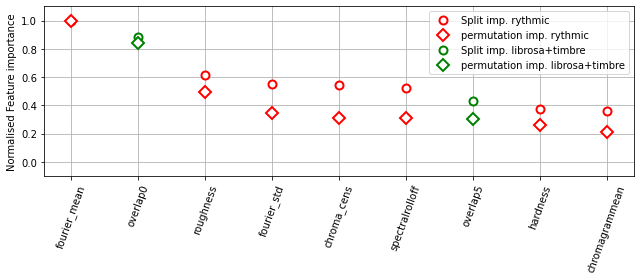

In [91]:

featImp = clf.feature_importances_
featName = clf.feature_name_

sorted_perm = r.importances_mean
sorted_perm = [x for _, x in sorted(zip(featImp,r.importances_mean),reverse=True)]
sorted_perm = sorted_perm[:len(r.importances_mean)]

sorted_labels = [x for _, x in sorted(zip(featImp,featName),reverse=True)]
sorted_columns = [x for _, x in sorted(zip(featImp,df_1.columns),reverse=True)]
sorted_columns = sorted_columns[:len(featImp)]
col='k'
hf=plt.figure(figsize=(9,4))
hf.clf()
ax=hf.add_subplot(111)
#     ax.plot(sorted_labels,sorted(clf.feature_importance(),reverse=True)/max(clf.feature_importance()), 
#             linestyle = 'none',color = col, markersize=10, marker = 'o', markerfacecolor = 'white', markeredgecolor = col, markeredgewidth=2)

for i, col in enumerate(sorted_columns):
    if ((col in columns_new_data) or (col in columns_new_data2)) or ((col=='allEarly') or (col=='allLate')) or (col=='synco'):
        col = 'g'
        ax.plot(sorted_labels[i],sorted(featImp,reverse=True)[i]/max(featImp), 
            linestyle = 'none',color = col, markersize=8, marker = 'o', markerfacecolor = 'white', markeredgecolor = col, markeredgewidth=2)
        ax.plot(sorted_labels[i],sorted(sorted_perm,reverse=True)[i]/max(sorted_perm), 
            linestyle = 'none',color = col, markersize=8, marker = 'D', markerfacecolor = 'white', markeredgecolor = col, markeredgewidth=2)
    else:
        col = 'r'
        ax.plot(sorted_labels[i],sorted(featImp,reverse=True)[i]/max(featImp), 
            linestyle = 'none',color = col, markersize=8, marker = 'o', markerfacecolor = 'white', markeredgecolor = col, markeredgewidth=2)
        ax.plot(sorted_labels[i],sorted(sorted_perm,reverse=True)[i]/max(sorted_perm), 
            linestyle = 'none',color = col, markersize=8, marker = 'D', markerfacecolor = 'white', markeredgecolor = col, markeredgewidth=2)
        
ax.set_xticks(np.arange(0,len(featImp),1))
ax.set_xticklabels(sorted_columns,rotation=70)
plt.ylim([-0.1,1.1])
plt.grid()
ax.set_ylabel('Normalised Feature importance')
ax.legend(['Split imp. rythmic','permutation imp. rythmic','Split imp. librosa+timbre','permutation imp. librosa+timbre'])

plt.tight_layout()

moreThan10pct = np.array(sorted_columns)[sorted(featImp,reverse=True) >=0.1*np.ones_like(featImp)]

# plt.savefig('plotsAfterGridsearch/PermImp_and_SplitImportance.png')

# [i for i, col in enumerate(sorted_columns) if col in columns_new_data]

In [103]:
sorted_columns[:7]
moreThan10pct

array(['fourier_mean', 'overlap0', 'chroma_cens', 'roughness',
       'spectralrolloff', 'fourier_std', 'chromagrammean', 'hardness',
       'boominess', 'onBeatHarmonic', 'overlap6', 'overlap5', 'warmth',
       'sharpness', 'chromagramstd', 'onBeatPercussive', 'overlap6Late',
       'overlap2Early', 'onBeat', 'brightness', 'overlap3Late',
       'tempoHarmonic', 'overlap5Early', 'overlap4Late', 'depth',
       'overlap4', 'overlap5Late', 'tempo', 'overlap2', 'overlap3Early',
       'tempoPercussive', 'overlap2Late', 'overlap1Early',
       'overlap4Early', 'reverb', 'overlap1', 'overlap6Early',
       'zerocrossing', 'synco', 'overlap3', 'overlap1Late'], dtype='<U16')

array([[0.45833333, 0.        , 0.        , 0.04166667, 0.125     ,
        0.04166667, 0.125     , 0.08333333, 0.08333333, 0.04166667],
       [0.        , 0.90909091, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.09090909],
       [0.        , 0.09677419, 0.41935484, 0.03225806, 0.        ,
        0.06451613, 0.12903226, 0.09677419, 0.        , 0.16129032],
       [0.        , 0.        , 0.        , 0.84      , 0.        ,
        0.        , 0.04      , 0.        , 0.04      , 0.08      ],
       [0.        , 0.        , 0.        , 0.        , 0.72727273,
        0.09090909, 0.        , 0.04545455, 0.13636364, 0.        ],
       [0.        , 0.04      , 0.08      , 0.        , 0.08      ,
        0.72      , 0.04      , 0.04      , 0.        , 0.        ],
       [0.        , 0.07692308, 0.07692308, 0.        , 0.        ,
        0.07692308, 0.69230769, 0.        , 0.        , 0.07692308],
       [0.        , 0.        , 0.       

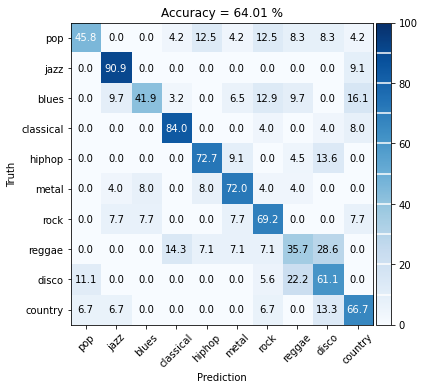

In [85]:
# score=precision_score(y_pred_lgb_probs_highest,y_val,average=None).mean()
# cmat = confusion_matrix(y_test,y_pred_m )

from mpl_toolkits.axes_grid1 import make_axes_locatable

cmat = confusion_matrix(y_test,y_pred_1,normalize='true' )
plt.figure(figsize=(6,6))
im = plt.imshow(cmat*100, cmap='Blues', vmin = 0, vmax=100)

texts = annotate_heatmap(im, valfmt="{x:.1f}")



cbticks=[10,20,30,40,50,60,70,80,90,100]

ax=plt.gca()
ax.set_xticks(np.array(chosen_genres))
ax.set_xticklabels([folders[genre_index] for genre_index in chosen_genres], rotation=45)

ax.set_yticks(np.array(chosen_genres))
ax.set_yticklabels([folders[genre_index] for genre_index in chosen_genres])
# cb=plt.colorbar(ticks=cbticks)
plt.title('Accuracy = {:.2f} %'.format(100*score))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

ax.set_xlabel('Prediction')
ax.set_ylabel('Truth')

cb=plt.colorbar(im, cax=cax)
cb.ax.plot([0,100],[cbticks, cbticks],'w')


# plt.savefig('plotsAfterGridsearch/top15CMAT_rythmicVars.pdf')
# plt.savefig('plotsAfterGridsearch/CMAT_AllVars.png')

plt.tight_layout()
len(y_pred_1)
cmat

In [86]:
#### calculate shap values
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_1)
shap_obj = explainer(X_1)

10

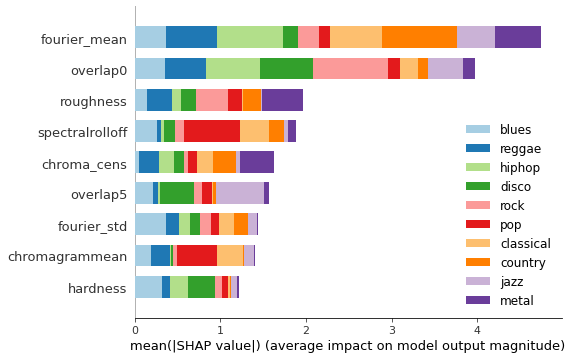

In [87]:
# evaluate shap values
# plt.grid()
# shap.summary_plot(shap_values, X_1, feature_names=df_1.columns, class_names=[folders[genre_index] for genre_index in chosen_genres],
#                  color=plt.get_cmap("Paired"),show=False)

shap.summary_plot(shap_values, X_1, feature_names=df_1.columns, class_names=[folders[genre_index] for genre_index in chosen_genres],
                 color=plt.get_cmap("Paired"),show=False)
# X_1.iloc[:,0])
# shap.plots.(shap_obj)
f=plt.gcf()
plt.tight_layout()
# plt.show()

top10SHAP = ['fourier_mean', 'overlap0','roughness','spectralrolloff','chroma_cens','chromagrammean','fourier_std','overlap5','hardness','boominess']
len(top10SHAP)
# plt.savefig('plotsAfterGridsearch/SHAP_values_AllVars.png')

In [ ]:
sorted_perm

In [139]:
distributions['learning_rate'].interval(alpha=0.7)

(-0.8374810705022251, 0.8971199848858811)

In [144]:
np.geomspace(1e-5,0.2,15)

array([1.00000000e-05, 2.02869346e-05, 4.11559714e-05, 8.34928498e-05,
       1.69381398e-04, 3.43622934e-04, 6.97105597e-04, 1.41421356e-03,
       2.86900580e-03, 5.82033329e-03, 1.18076721e-02, 2.39541470e-02,
       4.85956213e-02, 9.85856189e-02, 2.00000000e-01])

In [43]:
sorted(sorted_perm,reverse=True)[i]

'zerocrossing'